# Spatial localization of immune cells in the mouse spleen using DIRAC (cellbin)

- by CHANG XU changxu@nus.edu.sg.
- Last update: October 4th 2024

## Download the data （Under review, will be provided later）
- if you are have ``wget`` installed, you can run the following code to automatically download and unzip the data.

In [ ]:
# Skip this cells if data are already download
! wget -O B05050G1_cellbin_Protein.h5ad "*******"
! wget -O B05050G1_cellbin_domain_to_cellbin.h5ad "*******"

- if you do not have wget installed, manually download data from the links below:
    - Mouse spleen cellbin collected from ADT: "********************"
    - Mouse spleen cellbin collected from RNA: "********************"

In [1]:
import torch
import numpy as np
from builtins import range
from torch_geometric.data import InMemoryDataset, Data
from sklearn.metrics import pairwise_distances
import time
import spateo as st
import seaborn as sns

import pandas as pd
import anndata
import os 
import sys
import random
import matplotlib.pyplot as plt
import scanpy as sc
import logging
import sklearn
from collections import Counter
import yaml

import sodirac as sd

2024-12-07 16:02:39.272350: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-07 16:02:39.275299: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-07 16:02:39.283083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733558559.295990 1383242 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733558559.299893 1383242 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 16:02:39.314228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

[easydl] tensorflow not available!


In [2]:
def seed_torch(seed=1029):   
    random.seed(seed)    
    os.environ['PYTHONHASHSEED'] = str(seed)    
    np.random.seed(seed)    
    torch.manual_seed(seed)    
    torch.cuda.manual_seed(seed)    
    torch.cuda.manual_seed_all(seed) 
    # if you are using multi-GPU.    
    torch.backends.cudnn.benchmark = False    
    torch.backends.cudnn.deterministic = True

seed_torch(seed=8)

## Step 1: Align the cellbin data with the bin50 data using Stereopy
- This step is to remove the position of the mouse spleen capsule.

[<Axes: title={'center': 'region_domain'}, xlabel='spatial1', ylabel='spatial2'>]

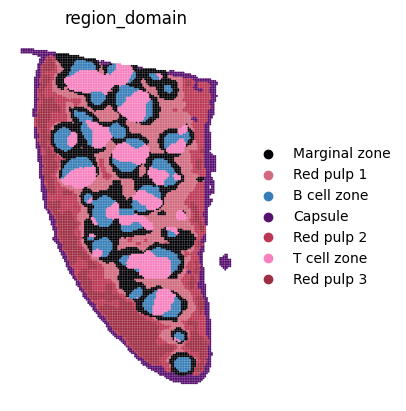

In [3]:
import os 
import sys
import random
import pandas as pd 
import numpy as np 
import torch
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import time

save_time = "20241206192908"

data_path = '/home/project/11003054/changxu/Data/Stereo_cite_seq/B05050G1/Stereo-CITE-seq'
data_name = "B05050G1_bin50"
methods = "Dirac"
save_path = f'/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/mouse_spleen/Results/B05050G1_bin50_Dirac/{save_time}'

adata_RNA = sc.read(os.path.join(save_path,f"{data_name}_{methods}_RNA_{save_time}.h5ad"))
adata_Protein = sc.read(os.path.join(save_path,f"{data_name}_{methods}_Protein_{save_time}.h5ad"))

adata_RNA = adata_RNA.raw.to_adata()
adata_Protein = adata_Protein.raw.to_adata()

# create a dictionary to map cluster to annotation label
cluster2annotation = {
    "C_1": "Marginal zone",
    "C_2": "Red pulp 1",
    "C_3": "B cell zone",
    "C_4": "Capsule",
    "C_5": "Red pulp 2",
    "C_6": "T cell zone",
    "C_7": "Red pulp 3",
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata_RNA.obs["region_domain"] = adata_RNA.obs['Combined_region'].map(cluster2annotation).astype("category")

########### save colors
cluster2colors = {
    "Marginal zone": '#000004ff',
    "Capsule": '#57106eff',
    "T cell zone": "#F781BF",
    "B cell zone": "#377EB8",
    "Red pulp 1":'#d16a7fff',
    "Red pulp 2":'#bc3754ff',
    "Red pulp 3":'#9e2e44ff',
}
sc.pl.spatial(adata_RNA, color=["region_domain"], palette=cluster2colors, frameon=False, spot_size=60, show=False)
# adata_RNA.write(os.path.join(save_path, f"{data_name}_{methods}_RNA_cluster_cellbin.h5ad"))

In [4]:
# ################### Align the data between bin50 and cellbin.
save_time = "20241206192908"
data_path = '/home/project/11003054/changxu/Data/Stereo_cite_seq/B05050G1/Stereo-CITE-seq'
data_name = "B05050G1_bin50"
methods = "Dirac"
save_path = f'/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/mouse_spleen/Results/B05050G1_bin50_Dirac/{save_time}'

adata_cellbin = st.io.read_h5ad(file_path=os.path.join(data_path, "B05050G1_cellbin_RNA.h5ad"))
adata_RNA_bin50 = st.io.read_h5ad(file_path=os.path.join(save_path, f"{data_name}_{methods}_RNA_cluster_cellbin.h5ad"))

st.utils.cluster_bins_to_cellbins(adata_RNA_bin50, adata_cellbin, 'region_domain')
adata_cellbin.cells["region_domain_from_bin50"] = adata_cellbin.cells["region_domain_from_bins"]
st.io.stereo_to_anndata(adata_cellbin, flavor='scanpy',output=os.path.join(data_path, "B05050G1_cellbin_to_bin50.h5ad"))

## Step 2: Run the horizontal integration task of DIRAC
- Annotation using ADT + RNA
- Annotation using RNA only
- Annotation using ADT only

### Step 2.1: ADT+RNA
- Load packages and data, including CITE-seq and Stereo-CITE-seq.
- Filter data and preprocess
- Run DIRAC's horizontal integration task
- Visualize the spatial distribution of mouse spleen cells

AnnData object with n_obs × n_vars = 167634 × 27497
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'region_domain_from_bins', 'region_domain_from_bin50'
    var: 'real_gene_name'
    uns: 'bin_size', 'bin_type', 'gene_exp_region_domain_from_bins', 'resolution', 'sn'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 167637 × 128
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y'
    var: 'real_gene_name'
    uns: 'bin_size', 'bin_type', 'resolution', 'sn'
    obsm: 'cell_border', 'spatial'
View of AnnData object with n_obs × n_vars = 160117 × 27497
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'region_domain_from_bins', 'region_domain_from_bin50', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_c

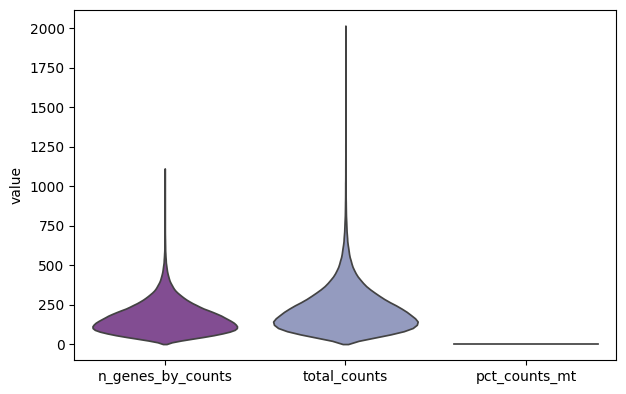

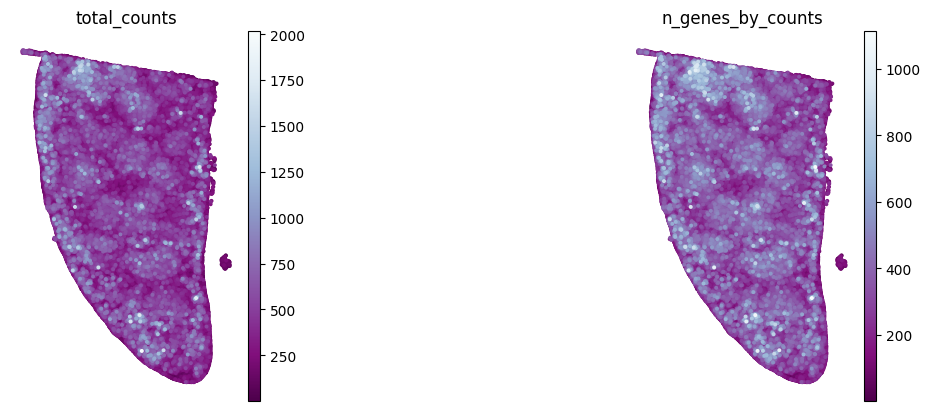

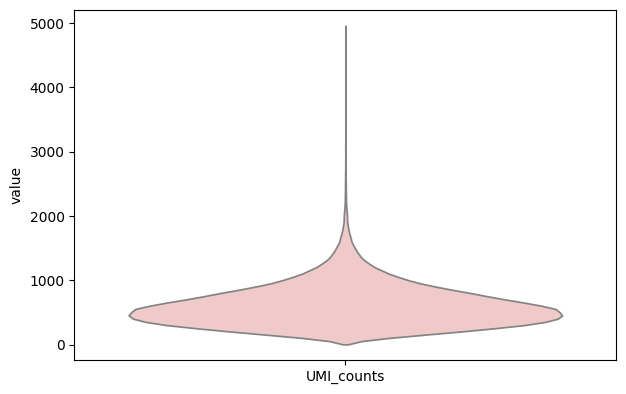

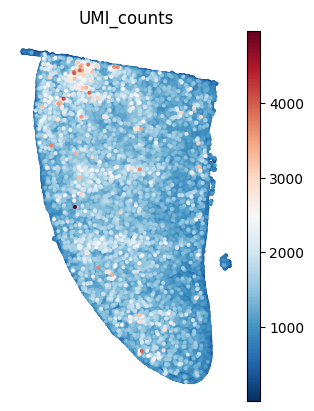

In [5]:
#######
data_path = '/home/project/11003054/changxu/Data/Stereo_cite_seq/B05050G1/Stereo-CITE-seq'
data_name = "B05050G1_cellbin"
methods = "Dirac"
use_obs_name = "cell_types"
save_path = "/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/mouse_spleen/Results"
now = time.strftime("%Y%m%d%H%M%S", time.localtime(time.time()))

save_path = os.path.join(save_path, f"{data_name}_{methods}", f"{now}")
if not os.path.exists(save_path):
	os.makedirs(save_path)

spleen_lymph_111 = anndata.read_h5ad(os.path.join(data_path, "spleen_lymph_111.h5ad"))
spleen_lymph_206 = anndata.read_h5ad(os.path.join(data_path, "spleen_lymph_206.h5ad"))

# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in spleen_lymph_111.uns["protein_names"]]
)
keep_pro_206 = np.array(
    [
        not (p.startswith("HTO") or p.startswith("ADT_Isotype"))
        for p in spleen_lymph_206.uns["protein_names"]
    ]
)
spleen_lymph_111.obsm["protein_expression"] = spleen_lymph_111.obsm["protein_expression"][
    :, keep_pro_111
]
spleen_lymph_111.uns["protein_names"] = spleen_lymph_111.uns["protein_names"][keep_pro_111]
spleen_lymph_206.obsm["protein_expression"] = spleen_lymph_206.obsm["protein_expression"][
    :, keep_pro_206
]
spleen_lymph_206.uns["protein_names"] = spleen_lymph_206.uns["protein_names"][keep_pro_206]

###### names need to be changed.
spleen_lymph_111.obs["cell_types"] = [names.replace('Cycling B/T cells', 'Cycling B or T cells') for names in spleen_lymph_111.obs["cell_types"]]
spleen_lymph_111.obs["cell_types"] = [names.replace('MZ/Marco-high macrophages', 'MZ or Marco-high macrophages') for names in spleen_lymph_111.obs["cell_types"]]

spleen_lymph_206.obs["cell_types"] = [names.replace('Cycling B/T cells', 'Cycling B or T cells') for names in spleen_lymph_206.obs["cell_types"]]
spleen_lymph_206.obs["cell_types"] = [names.replace('MZ/Marco-high macrophages', 'MZ or Marco-high macrophages') for names in spleen_lymph_206.obs["cell_types"]]

target_adata_RNA = anndata.read_h5ad(os.path.join(data_path, f"{data_name}_to_bin50.h5ad"))
target_adata_protein = anndata.read_h5ad(os.path.join(data_path,  f"{data_name}_Protein.h5ad"))

target_adata_RNA.var_names = target_adata_RNA.var["real_gene_name"].astype(str)
target_adata_RNA.var_names_make_unique()

print(target_adata_RNA)
print(target_adata_protein)

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
target_adata_RNA.var["mt"] = target_adata_RNA.var_names.str.startswith("MT-")
# ribosomal genes
target_adata_RNA.var["ribo"] = target_adata_RNA.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
target_adata_RNA.var["hb"] = target_adata_RNA.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    target_adata_RNA, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    target_adata_RNA,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    show = False,
	stripplot=False,
    palette = "BuPu_r"
    
)
plt.savefig(os.path.join(save_path, f"{data_name}_RNA_violin_QC.pdf"), dpi=300)
sc.pl.spatial(target_adata_RNA, color=["total_counts", "n_genes_by_counts"], cmap = "BuPu_r", frameon=False, spot_size=120, show = False,)
plt.savefig(os.path.join(save_path, f"{data_name}_RNA_spatial_QC.pdf"), dpi=300)

umi_counts = target_adata_protein.X.sum(axis=1).A1 if hasattr(target_adata_protein.X, "A1") else target_adata_protein.X.sum(axis=1)
target_adata_protein.obs["UMI_counts"] = umi_counts

sc.pl.violin(
    target_adata_protein,
    ["UMI_counts"],
    show = False,
	stripplot=False,
    palette = ["#F7C4C1"]
)
plt.savefig(os.path.join(save_path, f"{data_name}_Protein_violin_QC.pdf"), dpi=300)
sc.pl.spatial(target_adata_protein, color=["UMI_counts"], cmap = "RdBu_r", frameon=False, spot_size=120, show = False,)
plt.savefig(os.path.join(save_path, f"{data_name}_Protein_spatial_QC.pdf"), dpi=300)

########### remove capsule
target_adata_RNA = target_adata_RNA[~target_adata_RNA.obs['region_domain_from_bin50'].isin(["Capsule"])]
print(target_adata_RNA)
sc.pp.filter_cells(target_adata_RNA, min_genes=100)
sc.pp.filter_genes(target_adata_RNA, min_cells=5)
target_adata_RNA.uns["__type"] = 'UMI'
target_adata_RNA.obsm['spatial'] = target_adata_RNA.obsm['spatial'].astype("float32")

print(target_adata_RNA)

In [6]:
correspondence_dict = dict(zip(spleen_lymph_111.obs['leiden_subclusters'], spleen_lymph_111.obs['cell_types']))
print(correspondence_dict)

correspondence_dict = dict(zip(spleen_lymph_206.obs['leiden_subclusters'], spleen_lymph_206.obs['cell_types']))
print(correspondence_dict)

{'12,0': 'NKT', '6': 'CD122+ CD8 T', '3': 'Transitional B', '4': 'Mature B', '0': 'CD4 T', '9': 'Mature B', '8': 'Ifit3-high B', '2': 'CD8 T', '13': 'B1 B', '27': 'Activated CD4 T', '11': 'MZ B', '1': 'Mature B', '10,1': 'ICOS-high Tregs', '19': 'Cycling B or T cells', '7': 'Mature B', '16,0': 'B-macrophage doublets', '21': 'B doublets', '5': 'Mature B', '18': 'Ifit3-high CD8 T', '12,1': 'NK', '15,1': 'cDC1s', '28': 'pDCs', '20,0': 'Ly6-high mono', '22': 'GD T', '10,0': 'Tregs', '25': 'B-CD4 T cell doublets', '15,0': 'cDC2s', '16,1': 'MZ or Marco-high macrophages', '10,2': 'Tregs', '20,1': 'Ly6-low mono', '14': 'Ifit3-high CD4 T', '15,2': 'Migratory DCs', '16,2': 'Red-pulp macrophages', '16,3': 'Erythrocytes', '24,0': 'B-CD8 T cell doublets', '23': 'T doublets', '17': 'Low quality B cells', '24,1': 'Erythrocytes', '26': 'Neutrophils', '30': 'Neutrophils', '29': 'Low quality T cells', '24,2': 'Low quality T cells', '31': 'Plasma B'}
{'18': 'Ifit3-high CD8 T', '11': 'MZ B', '3': 'Transit

In [7]:
############ construct source data
source_adata_RNA = anndata.concat([spleen_lymph_111, spleen_lymph_206], join='inner')
sln_all_intersect_post = anndata.read_h5ad(os.path.join(data_path, "sln_all_intersect_post_adata.h5ad"))
sln_all_union_post = anndata.read_h5ad(os.path.join(data_path, "sln_all_union_post_adata.h5ad"))
source_adata_RNA.obsm["X_umap"] = sln_all_intersect_post.obsm["X_umap"]
del sln_all_intersect_post
del sln_all_union_post
# sc.pl.umap(source_adata_RNA, color = "cell_types", size=20, return_fig=True)

source_adata_RNA = source_adata_RNA[source_adata_RNA.obs["hash_id"].isin(["Spleen"])]

# Filter out unanalyzed clusters
include_cells = [
    c not in ['Cycling B or T cells','Low quality B cells', 'B doublets', 'B-macrophage doublets', 'B-CD4 T cell doublets', 'Ly6-low mono', 'B-CD8 T cell doublets',
             'T doublets', 'Erythrocytes', 'Low quality T cells', 'ICOS-high Tregs']  
    for c in source_adata_RNA.obs[use_obs_name]
]
source_adata_RNA = source_adata_RNA[include_cells]
source_adata_RNA.raw = source_adata_RNA.copy()

print(source_adata_RNA)
print(target_adata_RNA)

###### remove red blood cell genes and proterins
# Erythrocyte_genes = ["Hba-a1", "Hba-a2", "Hbb-b1", "Hbb-b2", "Hbb-y", "Hbb-z", "Hbb-bs", "Hbb-bt", "Epor", "Gata1", "Klf1", "Car1", "Slc4a1"]
# Erythrocyte_genes_source = [gene for gene in Erythrocyte_genes if gene in source_adata_RNA.var_names]
# Erythrocyte_genes_target = [gene for gene in Erythrocyte_genes if gene in target_adata_RNA.var_names]
# print(Erythrocyte_genes_source)
# print(Erythrocyte_genes_target)

# source_adata_RNA = source_adata_RNA[:, ~source_adata_RNA.var_names.isin(Erythrocyte_genes_source)].copy()
# target_adata_RNA = target_adata_RNA[:, ~target_adata_RNA.var_names.isin(Erythrocyte_genes_target)].copy()

# print(source_adata_RNA)
# print(target_adata_RNA)

# Organize and instantiate scVI dataset
hvg_111 = spleen_lymph_111.var["hvg_encode"]
hvg_206 = spleen_lymph_206.var["hvg_encode"]
assert (hvg_111 == hvg_206).all()
hvg = spleen_lymph_111.var[spleen_lymph_111.var['highly_variable']].index.tolist()

source_adata_raw = source_adata_RNA.copy()
sc.pp.normalize_total(source_adata_raw, target_sum=1e4)
sc.pp.log1p(source_adata_raw)
sc.tl.rank_genes_groups(source_adata_raw, groupby=use_obs_name, use_raw=False)
markers_df = pd.DataFrame(source_adata_raw.uns["rank_genes_groups"]["names"]).iloc[0:50, :]
markers = list(np.unique(markers_df.melt().value.values))
print(len(markers))

spleen_111_protein = anndata.AnnData(X=spleen_lymph_111.obsm["protein_expression"], obs=spleen_lymph_111.obs)
spleen_111_protein.var_names = spleen_lymph_111.uns['protein_names']
spleen_206_protein = anndata.AnnData(X=spleen_lymph_206.obsm["protein_expression"], obs=spleen_lymph_206.obs)
spleen_206_protein.var_names = spleen_lymph_206.uns['protein_names']

source_adata_protein = anndata.concat([spleen_111_protein, spleen_206_protein], join='inner')
source_adata_protein = source_adata_protein[source_adata_protein.obs["hash_id"].isin(["Spleen"])]
source_adata_protein = source_adata_protein[include_cells]
source_adata_protein.raw = source_adata_protein.copy()

AnnData object with n_obs × n_vars = 16035 × 13553
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types'
    obsm: 'protein_expression', 'X_umap'
AnnData object with n_obs × n_vars = 120117 × 21331
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'region_domain_from_bins', 'region_domain_from_bin50', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'real_gene_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'bi

In [8]:
print(source_adata_RNA.obs[use_obs_name].value_counts())
print(len(source_adata_RNA.obs[use_obs_name].unique()))

Mature B                        6060
Transitional B                  2529
CD4 T                           1636
MZ B                             889
CD8 T                            848
B1 B                             564
CD122+ CD8 T                     528
Ifit3-high B                     522
NKT                              331
Neutrophils                      303
NK                               285
Ly6-high mono                    243
cDC2s                            241
cDC1s                            194
Tregs                            178
GD T                             163
Ifit3-high CD4 T                 129
Red-pulp macrophages             122
pDCs                              74
Ifit3-high CD8 T                  68
Activated CD4 T                   39
Migratory DCs                     37
MZ or Marco-high macrophages      34
Plasma B                          18
Name: cell_types, dtype: int64
24


In [9]:
import re
pattern = re.compile(r'ADT_(.*?)_A\d+')
source_adata_protein.var_names = [pattern.search(s).group(1) for s in source_adata_protein.var_names]

def remove_parentheses(text):
    return re.sub(r'\(.*?\)', '', text)

source_adata_protein.var_names = [remove_parentheses(item) for item in source_adata_protein.var_names]
source_adata_protein.var_names = [s.replace('-', '_') for s in source_adata_protein.var_names]
source_adata_protein.var_names = [s.replace('.', '_') for s in source_adata_protein.var_names]
print(source_adata_protein.var_names.tolist())

['CD102', 'CD103', 'CD106', 'CD115', 'CD117', 'CD11a', 'CD11c', 'CD122', 'CD127', 'CD134', 'CD135', 'CD137', 'CD14', 'CD140a', 'CD15', 'CD150', 'CD16_32', 'CD169', 'CD172a', 'CD183', 'CD184', 'CD19', 'CD192', 'CD195', 'CD196', 'CD197', 'CD20', 'CD200', 'CD201', 'CD204', 'CD206', 'CD21_CD35', 'CD223', 'CD23', 'CD24', 'CD25', 'CD274', 'CD278', 'CD279', 'CD28', 'CD29', 'CD300LG', 'CD301a', 'CD301b', 'CD304', 'CD326', 'CD335', 'CD357', 'CD36', 'CD366', 'CD370', 'CD38', 'CD4', 'CD41', 'CD43', 'CD45', 'CD45_1', 'CD45_2', 'CD45R_B220', 'CD48', 'CD49d', 'CD5', 'CD54', 'CD55', 'CD62L', 'CD62P', 'CD63', 'CD64', 'CD68', 'CD69', 'CD71', 'CD73', 'CD79b', 'CD83', 'CD86', 'CD8a', 'CD8b', 'CD90_1', 'CD90_2', 'CD93', 'CX3CR1', 'ESAM', 'F4_80', 'FceRIa', 'FolateReceptorb', 'H_2KbboundtoSIINFEKL', 'I_A_I_E', 'IRF4', 'IgD', 'IgM', 'Ly_6A_E', 'Ly_6C', 'MAdCAM_1', 'MERTK', 'NK_1_1', 'Notch1', 'PanendothelialCellAntigen', 'SiglecH', 'TCRVb5_1_5_2', 'TCRVb8_1_8_2', 'TCRVr1_1_Cr4', 'TCRVr2', 'TCRVr3', 'TCRbcha

In [10]:
target_adata_protein.var_names = [s.replace('_Ms', '') for s in target_adata_protein.var_names]
print(target_adata_protein.var_names.tolist())

['CD102', 'CD103', 'CD106', 'CD107a', 'CD115', 'CD11a', 'CD11b', 'CD11c', 'CD120b', 'CD127', 'CD134', 'CD137', 'CD138', 'CD150', 'CD155', 'CD159a', 'CD160', 'CD163', 'CD169', 'CD170', 'CD172a', 'CD185', 'CD186', 'CD19', 'CD199', 'CD1d', 'CD2', 'CD20', 'CD200', 'CD200R', 'CD200R3', 'CD205', 'CD21_35', 'CD22', 'CD223', 'CD226_10E5', 'CD23', 'CD24', 'CD25', 'CD26', 'CD27', 'CD270', 'CD272', 'CD274', 'CD279', 'CD29', 'CD3', 'CD301a', 'CD301b', 'CD304', 'CD31', 'CD317', 'CD357', 'CD36', 'CD366', 'CD371', 'CD38', 'CD4', 'CD40', 'CD41', 'CD43', 'CD44', 'CD45', 'CD45R', 'CD45_2', 'CD48', 'CD49a', 'CD49b', 'CD49d', 'CD49f', 'CD5', 'CD51', 'CD54', 'CD55', 'CD61', 'CD62L', 'CD63', 'CD64', 'CD68', 'CD69', 'CD71', 'CD73', 'CD79b', 'CD81', 'CD83', 'CD85k', 'CD86', 'CD8a', 'CD8b', 'CD9', 'CD90_2', 'CD93', 'CD94', 'CX3CR1', 'F4_80', 'FceRIa', 'IL-33Ra', 'I_A_I_E', 'IgD', 'IgM', 'Integrin_b7', 'Isotype_Ham_IgG', 'Isotype_IgG1k', 'Isotype_IgG2ak', 'Isotype_IgG2bk', 'Isotype_Rat_IgG1k', 'Isotype_Rat_IgG1

In [11]:
######### First, use the source proteome to modify the target protein names
source_adata_protein.var_names = [protein.replace('CD21_CD35', 'CD21_35') for protein in source_adata_protein.var_names]
source_adata_protein.var_names = [protein.replace('CD45R_B220', 'CD45RHu') for protein in source_adata_protein.var_names]
source_adata_protein.var_names = [protein.replace('NK_1_1', 'NK1_1') for protein in source_adata_protein.var_names]
source_adata_protein.var_names = [protein.replace('TCRr_d', 'TCR_r_d') for protein in source_adata_protein.var_names]
source_adata_protein.var_names = [protein.replace('TCRbchain', 'TCR_b') for protein in source_adata_protein.var_names]
source_adata_protein.var_names = [protein.replace('TER_119_ErythroidCells', 'TER119') for protein in source_adata_protein.var_names]
source_adata_protein.var_names = [protein.replace('Tim_4', 'Tim4') for protein in source_adata_protein.var_names]
source_adata_protein.var_names = [protein.replace('Ly_6C', 'Ly6C') for protein in source_adata_protein.var_names]
source_adata_protein.var_names = [protein.replace('Ly_6A_E', 'Ly6A_E') for protein in source_adata_protein.var_names]
source_adata_protein.var_names = [protein.replace('integrinb7', 'Integrin_b7Hu') for protein in source_adata_protein.var_names]

# Find the intersection of protein names between source and target data
intersection = list(set(source_adata_protein.var_names) & set(target_adata_protein.var_names))

######################### Keep only the intersecting proteins
source_adata_protein = source_adata_protein[:,intersection]
target_adata_protein = target_adata_protein[:,intersection]

######### Remove erythrocyte proteins
# source_adata_protein = source_adata_protein[:, ~source_adata_protein.var_names.isin(['TER119'])].copy()
# target_adata_protein = target_adata_protein[:, ~target_adata_protein.var_names.isin(['TER119'])].copy()

# Obtain the common variable names (gene names), ensuring marker genes are included
common_genes = list(set(source_adata_RNA.var_names) & set(target_adata_RNA.var_names) & set(markers) & set(hvg)) # & set(markers)

# Reindex the two AnnData objects, keeping only the common genes
target_adata_RNA = target_adata_RNA[:, common_genes]
source_adata_RNA = source_adata_RNA[:, common_genes]


In [12]:
print(source_adata_protein.var_names)
print(target_adata_protein.var_names)

Index(['CD137', 'CD19', 'FceRIa', 'CD279', 'CD64', 'CD115', 'Tim4', 'CD106',
       'CD172a', 'CD49d', 'CD223', 'CD21_35', 'TCR_r_d', 'CD200', 'Ly6A_E',
       'CD86', 'IgD', 'F4_80', 'CD63', 'CD73', 'CD29', 'CD169', 'CD48',
       'CD274', 'I_A_I_E', 'IgM', 'TER119', 'CD41', 'CD8a', 'CD23', 'CD150',
       'CD45', 'CD36', 'CD71', 'CX3CR1', 'CD103', 'CD54', 'CD93', 'NK1_1',
       'CD301b', 'XCR1', 'Ly6C', 'CD55', 'TCR_b', 'CD134', 'CD4', 'CD24',
       'CD304', 'CD83', 'CD11c', 'CD79b', 'CD38', 'CD127', 'CD25', 'CD68',
       'CD69', 'CD102', 'SiglecH', 'CD8b', 'CD45_2', 'CD20', 'CD366', 'CD301a',
       'CD357', 'CD43', 'CD5', 'CD90_2', 'CD11a', 'CD62L'],
      dtype='object')
Index(['CD137', 'CD19', 'FceRIa', 'CD279', 'CD64', 'CD115', 'Tim4', 'CD106',
       'CD172a', 'CD49d', 'CD223', 'CD21_35', 'TCR_r_d', 'CD200', 'Ly6A_E',
       'CD86', 'IgD', 'F4_80', 'CD63', 'CD73', 'CD29', 'CD169', 'CD48',
       'CD274', 'I_A_I_E', 'IgM', 'TER119', 'CD41', 'CD8a', 'CD23', 'CD150',
       'CD

In [13]:
print(source_adata_RNA.var_names)
print(target_adata_RNA.var_names)

Index(['Ctss', 'Cd44', 'Smpdl3a', 'Wdr43', 'Eif5a', 'Prkcd', 'Ssr4', 'Selplg',
       'Eaf2', 'Mzb1',
       ...
       'Derl3', 'Hsp90ab1', 'Sptssa', 'Pafah1b3', 'Cd3e', 'Cd82', 'Nop58',
       'Bhlhe41', 'Cd28', 'Itgal'],
      dtype='object', name='index', length=483)
Index(['Ctss', 'Cd44', 'Smpdl3a', 'Wdr43', 'Eif5a', 'Prkcd', 'Ssr4', 'Selplg',
       'Eaf2', 'Mzb1',
       ...
       'Derl3', 'Hsp90ab1', 'Sptssa', 'Pafah1b3', 'Cd3e', 'Cd82', 'Nop58',
       'Bhlhe41', 'Cd28', 'Itgal'],
      dtype='object', name='real_gene_name', length=483)


In [14]:
print(target_adata_RNA.obs_names)
print(target_adata_protein.obs_names)

Index(['32981053871356', '32963874002158', '32890859558133', '32817845114106',
       '32744830670058', '32654636356847', '34054795695300', '33990371185895',
       '33947421512919', '33908766807278',
       ...
       '52059298609667', '52042118740498', '51990579132964', '51981989198356',
       '51930449590832', '51926154623497', '51831665342999', '51827370375684',
       '51797305604652', '51724291160610'],
      dtype='object', length=120117)
Index(['29545080034301', '29682518987840', '29682518987781', '29669634085938',
       '29618094478408', '29600914609200', '29596619641879', '29549375001669',
       '29523605197872', '29510720295967',
       ...
       '52819507821082', '52780853115436', '52780853115419', '51672751553282',
       '51569672338178', '51380693777153', '51281909529347', '51067161164544',
       '50714973846276', '50594714761984'],
      dtype='object', length=167637)


In [15]:
#########################construct a Protein+RNA database
source_adata_total = anndata.AnnData(X=np.concatenate((source_adata_RNA.X, source_adata_protein.X), axis=1))
source_adata_total.obs = source_adata_RNA.obs
source_adata_total.var_names = source_adata_RNA.var_names.tolist() + source_adata_protein.var_names.tolist()

########################
target_adata_protein = target_adata_protein[target_adata_RNA.obs_names,:]
target_adata_total = anndata.AnnData(X=np.concatenate((target_adata_RNA.X.toarray(), target_adata_protein.X.toarray()), axis=1))
target_adata_total.obs = target_adata_RNA.obs
target_adata_total.var_names = target_adata_RNA.var_names.tolist() + target_adata_protein.var_names.tolist()
target_adata_total.obsm["spatial"] = target_adata_protein[target_adata_RNA.obs_names,:].obsm["spatial"]

In [16]:
print(target_adata_RNA.obs_names)
print(target_adata_protein.obs_names)

Index(['32981053871356', '32963874002158', '32890859558133', '32817845114106',
       '32744830670058', '32654636356847', '34054795695300', '33990371185895',
       '33947421512919', '33908766807278',
       ...
       '52059298609667', '52042118740498', '51990579132964', '51981989198356',
       '51930449590832', '51926154623497', '51831665342999', '51827370375684',
       '51797305604652', '51724291160610'],
      dtype='object', length=120117)
Index(['32981053871356', '32963874002158', '32890859558133', '32817845114106',
       '32744830670058', '32654636356847', '34054795695300', '33990371185895',
       '33947421512919', '33908766807278',
       ...
       '52059298609667', '52042118740498', '51990579132964', '51981989198356',
       '51930449590832', '51926154623497', '51831665342999', '51827370375684',
       '51797305604652', '51724291160610'],
      dtype='object', length=120117)


In [17]:
print(source_adata_total)
print(target_adata_total)

AnnData object with n_obs × n_vars = 16035 × 552
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types'
AnnData object with n_obs × n_vars = 120117 × 552
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'region_domain_from_bins', 'region_domain_from_bin50', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    obsm: 'spatial'


In [18]:
######################### Training ADT+RNA model
use_counts = "Total"
common_features = list(set(source_adata_total.var_names) & (set(target_adata_total.var_names)))
source_adata_total = source_adata_total[:,common_features].copy()
target_adata_total = target_adata_total[:,common_features].copy()

print(source_adata_total.shape)
print(target_adata_total.shape)

source_adata_total.obs[f"{use_obs_name}_num"] = source_adata_total.obs[f"{use_obs_name}"].astype('category').cat.codes

###### color-cell_type list
colormaps_clusters = {'Red-pulp macrophages': '#1b4400', 'GD T': '#8fb0ff', 'Ifit3-high B': '#006fa6', 'MZ or Marco-high macrophages': '#6b7900',
 'Ly6-low mono': '#5a0007','Transitional B': '#ff34ff','NKT': '#ffff00','NK': '#0000a6','Migratory DCs': '#ba0900','Ly6-high mono': '#004d43',
 'B1 B': '#008941','cDC1s': '#63ffac','Activated CD4 T': '#61615a','Ifit3-high CD8 T': '#809693','Mature B': '#ff4a46','Ifit3-high CD4 T': '#3b5dff',
 'ICOS-high Tregs': '#4fc601','Neutrophils': '#4a3b53','Plasma B': '#00c2a0','CD4 T': '#ffdbe5','Tregs': '#ff2f80','cDC2s': '#997d87','CD8 T': '#7a4900',
 'pDCs': '#b79762','Erythrocytes': '#1b4400','MZ B': '#a30059','CD122+ CD8 T': '#1ce6ff'}

total_save_path = os.path.join(save_path, f"{use_counts}")
if not os.path.exists(total_save_path):
    os.makedirs(total_save_path)


source_adata_total.obs["batch"] = "Source"
target_adata_total.obs["batch"] = "Target"
pairs = dict(set(zip(source_adata_total.obs[f"{use_obs_name}_num"], source_adata_total.obs[f"{use_obs_name}"])))
source_label = source_adata_total.obs[f"{use_obs_name}_num"].values
source_regions = source_adata_total.obs["batch"].values
target_regions = target_adata_total.obs["batch"].values

sc.pp.normalize_total(source_adata_total, target_sum=1e4)
sc.pp.log1p(source_adata_total)
sc.pp.scale(source_adata_total)
sc.pp.pca(source_adata_total)

sc.pp.normalize_total(target_adata_total, target_sum=1e4)
sc.pp.log1p(target_adata_total)
sc.pp.scale(target_adata_total)

source_adata_total.obsm["X_HVG"] = source_adata_total.X
target_adata_total.obsm["X_HVG"] = target_adata_total.X

source_adata_total.obsm["X_HVG"] = source_adata_total.obsm["X_HVG"].astype("float32")
target_adata_total.obsm["X_HVG"] = target_adata_total.obsm["X_HVG"].astype("float32")

(16035, 552)
(120117, 552)


In [19]:
source_edge_index = sd.utils.get_multi_edge_index(source_adata_total.obsm["X_pca"].copy(), source_adata_total.obs[f"{use_obs_name}"].copy().to_numpy(), n_neighbors = 8) #batch_indices f"{use_obs_name}"
source_edge_index = torch.LongTensor(source_edge_index).T
target_adata_total.obsm['spatial'] = target_adata_total.obsm['spatial'].astype('float32')
target_edge_index = sd.utils.get_single_edge_index(target_adata_total.obsm["spatial"].copy(), n_neighbors = 8)
target_edge_index = torch.LongTensor(target_edge_index).T

In [20]:
total_save_path 

'/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/mouse_spleen/Results/B05050G1_cellbin_Dirac/20241207160345/Total'

In [21]:
# Clear GPU memory
torch.cuda.empty_cache()
semisuper = sd.main.annotate_app(save_path = total_save_path, use_gpu=True)
samples = semisuper._get_data(
                source_data = source_adata_total.obsm["X_HVG"].copy(),
                source_label = source_label,
                source_edge_index = source_edge_index,
                target_data = target_adata_total.obsm["X_HVG"].copy(),
                target_edge_index = target_edge_index,
                source_domain = np.zeros(source_adata_total.shape[0]),
                target_domain = np.ones(target_adata_total.shape[0]),
                num_parts_source = source_adata_total.shape[0] // 256,
                num_parts_target = target_adata_total.shape[0] // 512,
                weighted_classes = False,)

models = semisuper._get_model(samples=samples, opt_GNN = "SAGE")
results = semisuper._train_dirac_annotate(samples=samples, models=models, n_epochs=50)
np.save(os.path.join(save_path, f"{data_name}_{methods}_Results.npy"), results)

Found 2 unique domains.


Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
Dirac annotate training..: 100%|█| 50/50 [00:53<00:00,


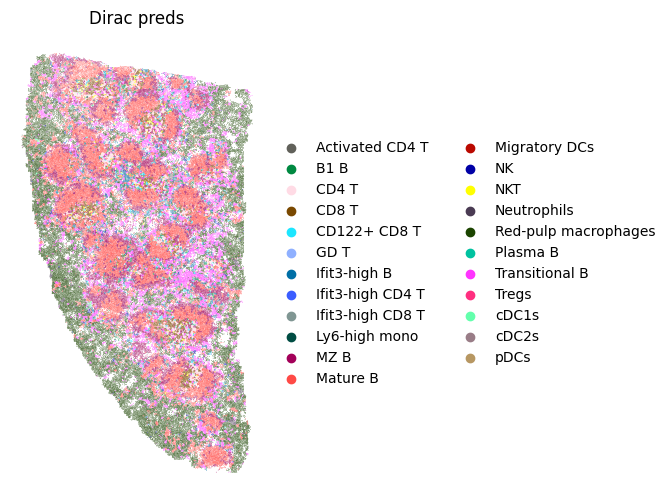

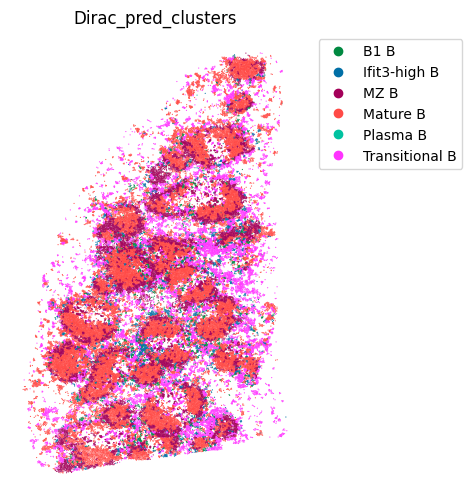

<Figure size 640x480 with 0 Axes>

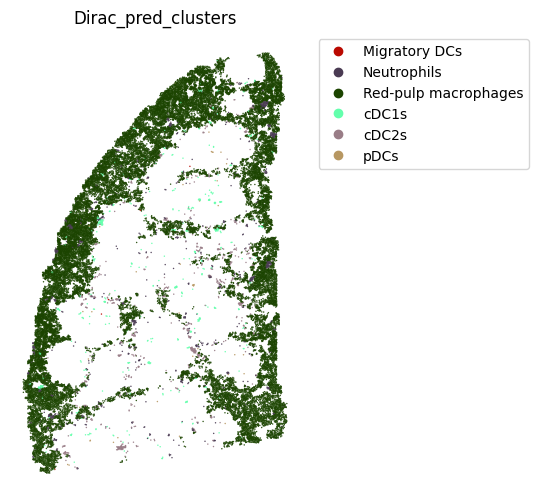

<Figure size 640x480 with 0 Axes>

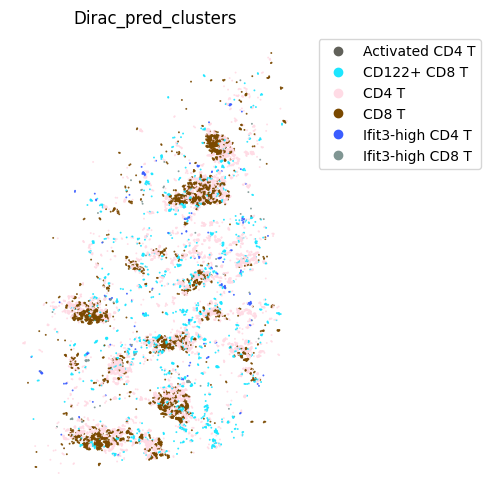

<Figure size 640x480 with 0 Axes>

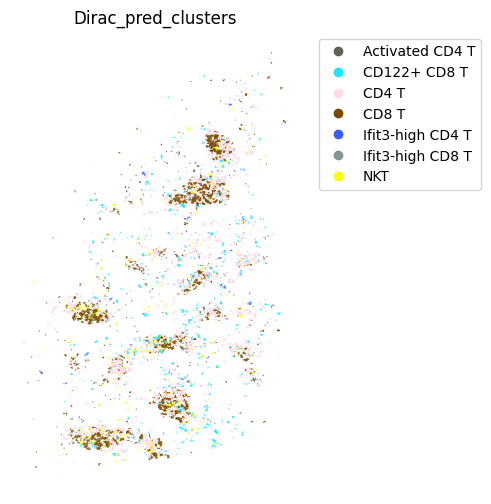

<Figure size 640x480 with 0 Axes>

In [92]:
source_adata_total.obsm[f"{methods}_embed"] = results["source_feat"]
target_adata_total.obsm[f"{methods}_embed"] = results["target_feat"]
target_adata_total.obs[f"{methods}_confs"] = results["target_confs"]
target_adata_total.obs[f"{methods}_pred_num"] = results["target_pred"]
target_adata_total.obs[f"{methods}_pred_clusters"] = target_adata_total.obs[f"{methods}_pred_num"].map(pairs)
print(Counter(target_adata_total.obs[f"{methods}_pred_clusters"]))

fig, ax = plt.subplots(figsize=(8, 6))

sc.pl.spatial(target_adata_total, 
              color=[f"{methods}_pred_clusters"], 
              frameon=False, 
              spot_size=15, 
              title=["Dirac preds"], 
              palette = colormaps_clusters,
              img_key = None,
              ax=ax)
fig.savefig(os.path.join(total_save_path, f"{data_name}_cell_type.pdf"), bbox_inches='tight', dpi = 300)


target_adata_total.uns['__type'] = "UMI"
fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_total[target_adata_total.obs[f"{methods}_pred_clusters"].isin(['Transitional B', 'Mature B', 'Plasma B',
                                                                                'Ifit3-high B', 'B1 B', 'MZ B'])], #, 'Erythrocytes'
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.05,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(total_save_path, f"{data_name}_{methods}_B_spateo.pdf"), dpi = 600)


fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_total[target_adata_total.obs[f"{methods}_pred_clusters"].isin(['Red-pulp macrophages', 'Migratory DCs', 'pDCs', 
                                                        'cDC1s', 'cDC2s','Neutrophils', 'MZ or Marco-high macrophages'])], #, 
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.05,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(total_save_path, f"{data_name}_{methods}_Red_pulp_spateo.pdf"), dpi = 600)


fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_total[target_adata_total.obs[f"{methods}_pred_clusters"].isin(['Activated CD4 T', 'Ifit3-high CD4 T','CD4 T', 'CD8 T', 
                                                                                'CD122+ CD8 T', 'Ifit3-high CD8 T'])], #, 
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.05,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(total_save_path, f"{data_name}_{methods}_T_spateo.pdf"), dpi = 600)


fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_total[target_adata_total.obs[f"{methods}_pred_clusters"].isin(['Activated CD4 T', 'Ifit3-high CD4 T','CD4 T', 'CD8 T', 
                                                                                'CD122+ CD8 T', 'Ifit3-high CD8 T', 'NKT'])], #, 
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.02,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(total_save_path, f"{data_name}_{methods}_T_NKT_spateo.pdf"), dpi = 600)

# plt.tight_layout()
# plt.show() 
# fig.savefig(os.path.join(save_path, f"{data_name}_{methods}_cell_type_B_spateo.png"), dpi = 600)

# for i in ["Red-pulp macrophages", 'Transitional B', 'Mature B', 'Migratory DCs', 'Erythrocytes']:
#     fig, ax = plt.subplots(figsize=(8, 6))
#     sc.pl.spatial(target_adata_total, 
#                   color=[f"{methods}_pred_clusters"], 
#                   groups=[i], 
#                   frameon=False, 
#                   spot_size=15, 
#                   title=["Dirac preds"], 
#                   palette = colormaps_clusters,
#                   img_key = None,
#                   ax=ax,
#                  )

# save_fig_path = os.path.join(save_path, "Single_cell_type")
# if not os.path.exists(save_fig_path):
#     os.makedirs(save_fig_path)

# for i in target_adata_total.obs[f"{methods}_pred_clusters"].unique():
#     fig, ax = plt.subplots(figsize=(8, 6))
#     sc.pl.spatial(target_adata_total, 
#                   color=[f"{methods}_pred_clusters"], 
#                   groups=[i], 
#                   frameon=False, 
#                   spot_size=15, 
#                   title=["Dirac preds"], 
#                   palette = colormaps_clusters,
#                   img_key = None,
#                   ax=ax,
#                  )
#     fig.savefig(os.path.join(save_fig_path, f"{data_name}_{i}.pdf"), bbox_inches='tight', dpi = 300)

In [27]:
save_path

'/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/mouse_spleen/Results/B05050G1_cellbin_Dirac/20241207160345'

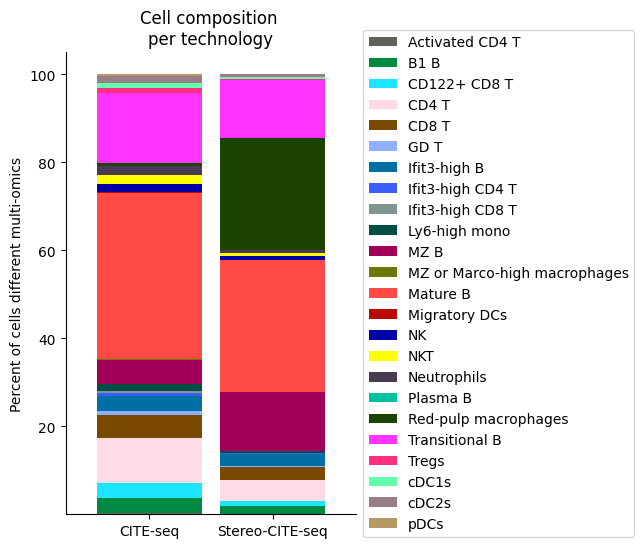

In [28]:
###########
# Use this ordering of cell types for consistency
import seaborn as sns

# Get cluster labels
source_spleen_clusters = pd.Series(source_adata_total.obs["cell_types"].values)
target_spleen_clusters = pd.Series(target_adata_total.obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp  = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp = target_spleen_clusters.value_counts()/np.sum(target_spleen_clusters.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, "Stereo-CITE-seq": target_spleen_comp}))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("Cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(save_path,"all_cell_composition_per_tissue.pdf"), dpi=300, bbox_inches='tight')

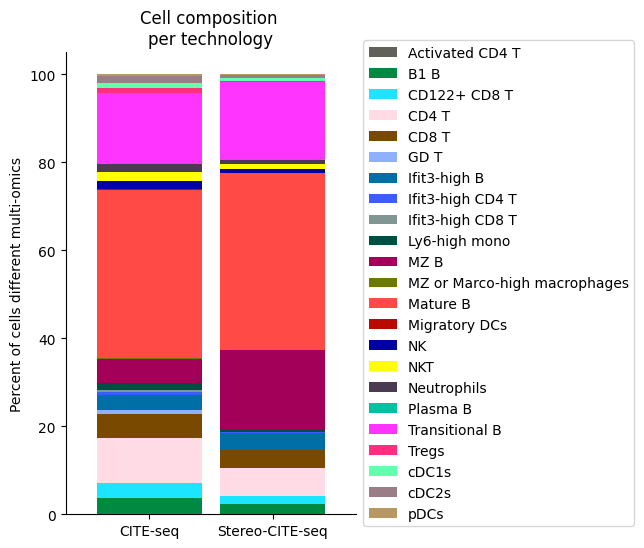

In [29]:
###########
# Use this ordering of cell types for consistency
import seaborn as sns


# Get cluster labels
source_spleen_clusters = pd.Series(source_adata_total[~source_adata_total.obs["cell_types"].isin(['Red-pulp macrophages'])].obs["cell_types"].values)
target_spleen_clusters = pd.Series(target_adata_total[~target_adata_total.obs["Dirac_pred_clusters"].isin(['Red-pulp macrophages'])].obs["Dirac_pred_clusters"].values)


# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp  = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp = target_spleen_clusters.value_counts()/np.sum(target_spleen_clusters.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, "Stereo-CITE-seq": target_spleen_comp}))
composition_df

colormap_dict = {k: v for k, v in colormaps_clusters.items() if k != 'Red-pulp macrophages'}
# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormap_dict),
plt.ylabel("Percent of cells different multi-omics")
plt.title("Cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(save_path,"allcell_composition_per_tissue_delete_Red_pulp_macrophages.pdf"), dpi=300, bbox_inches='tight')

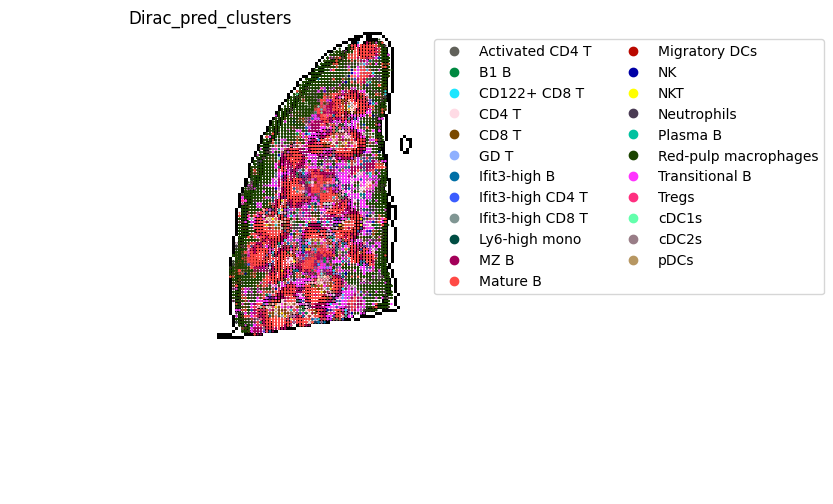

<Figure size 640x480 with 0 Axes>

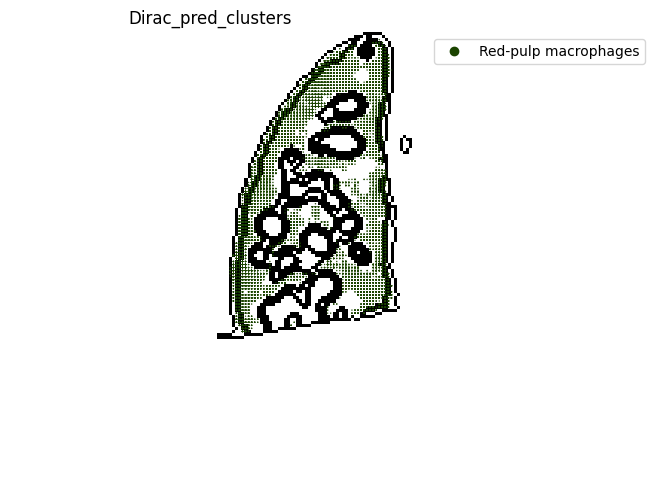

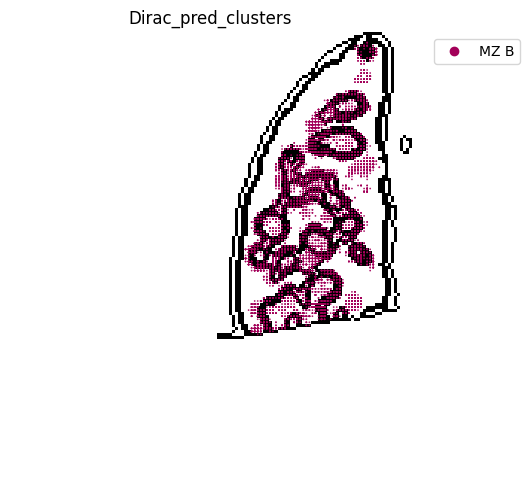

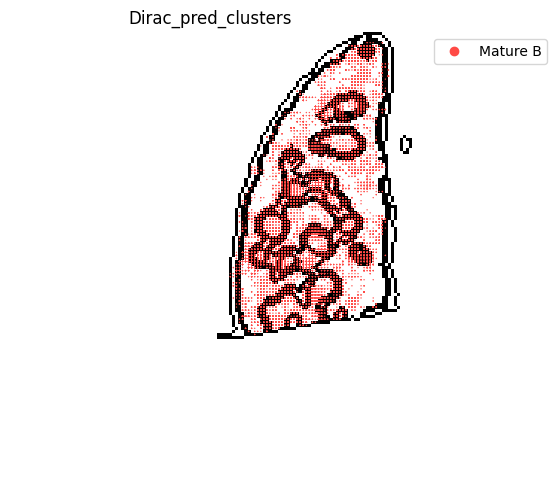

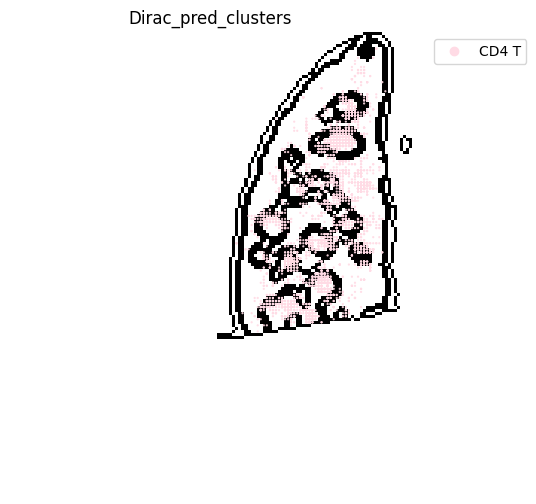

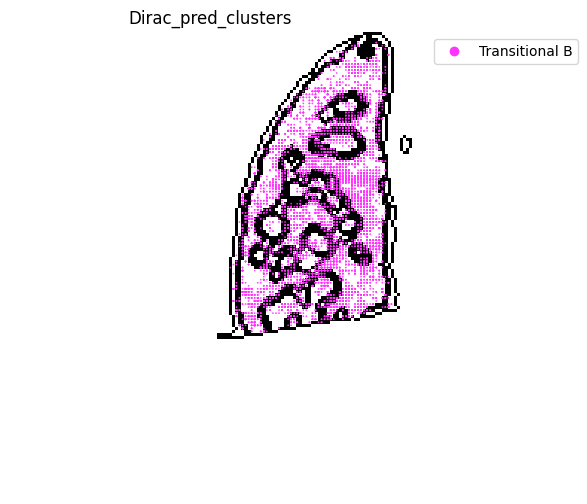

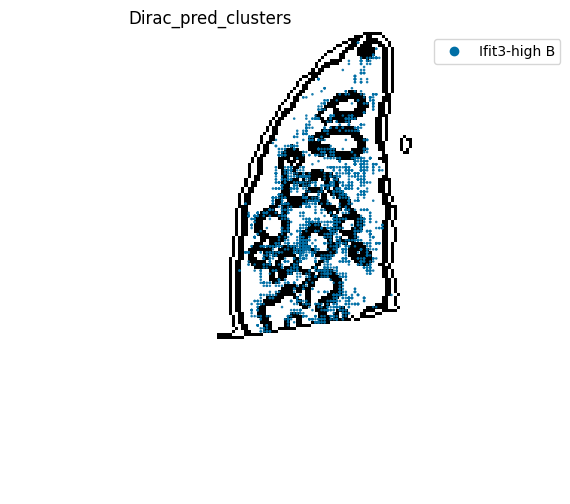

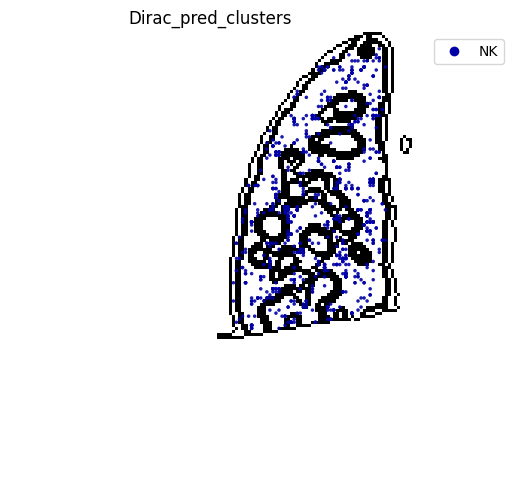

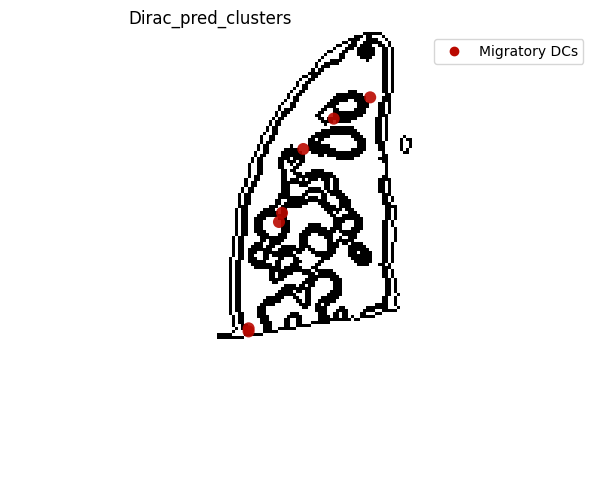

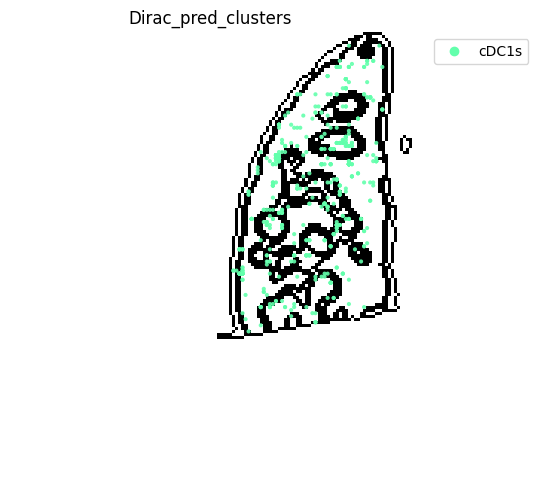

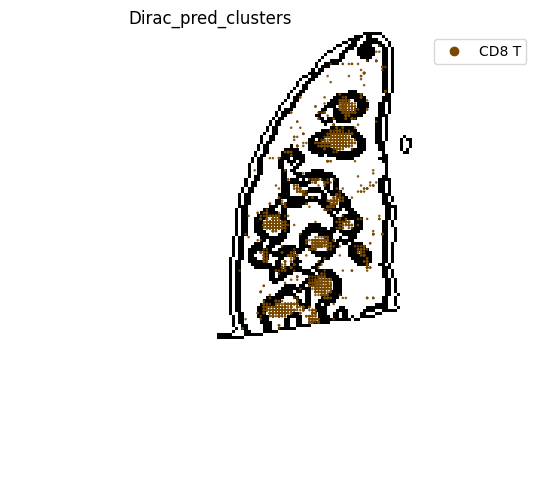

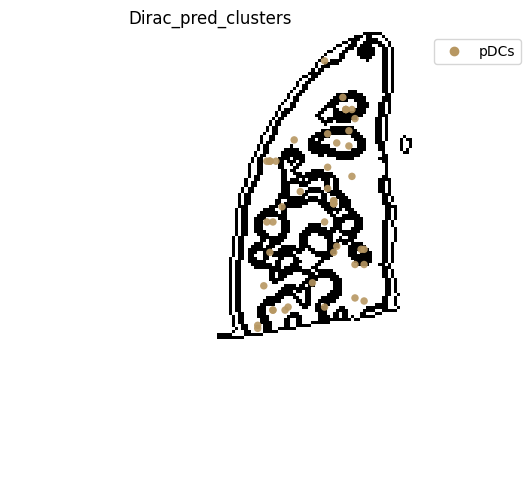

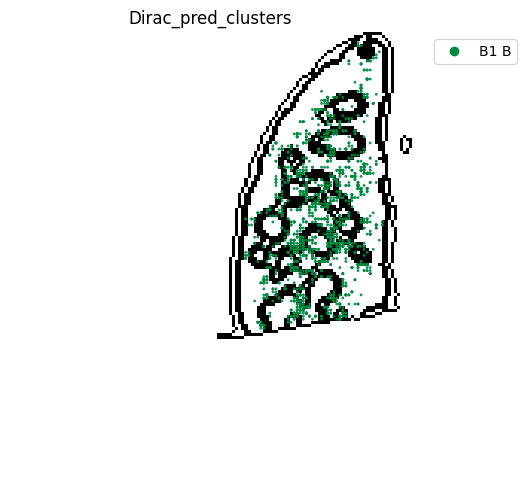

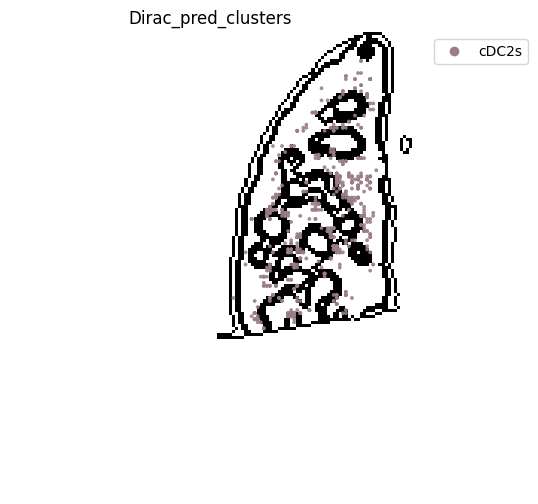

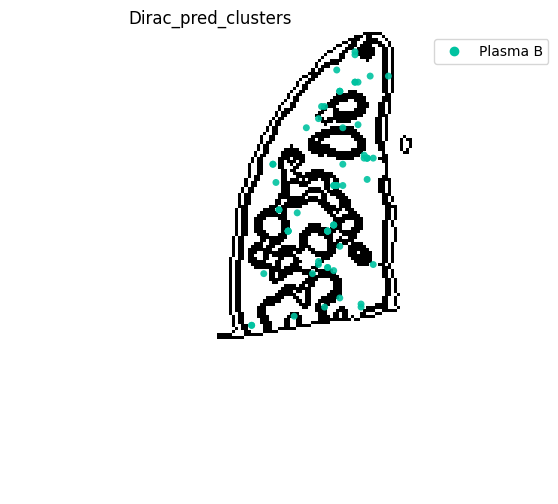

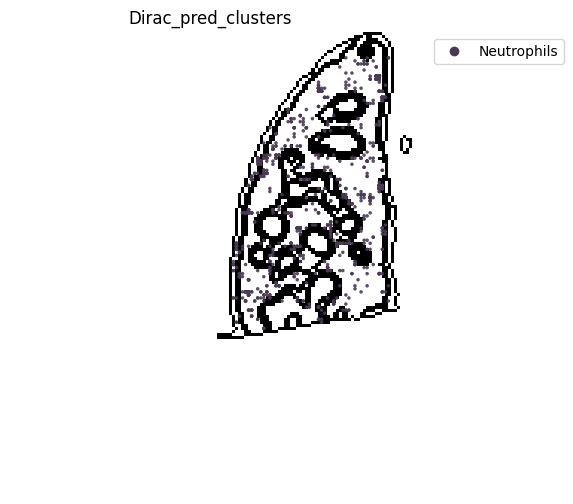

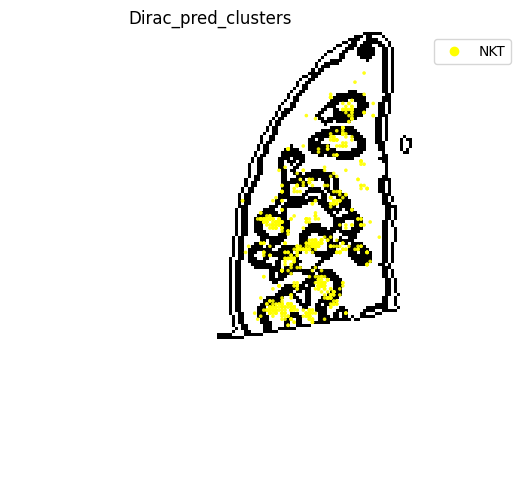

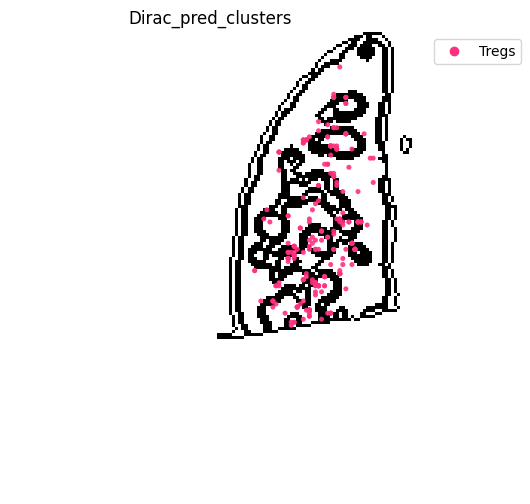

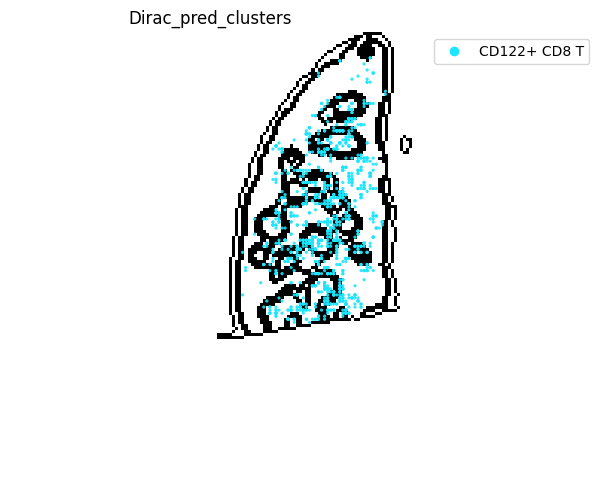

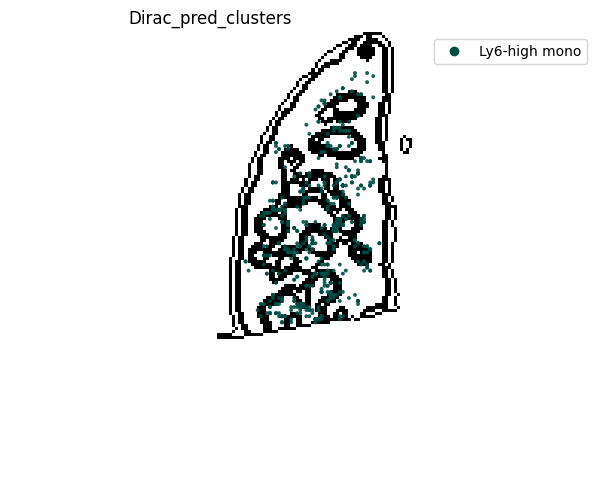

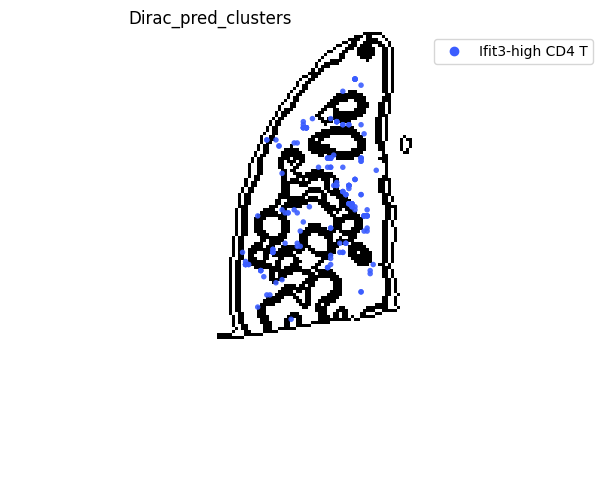

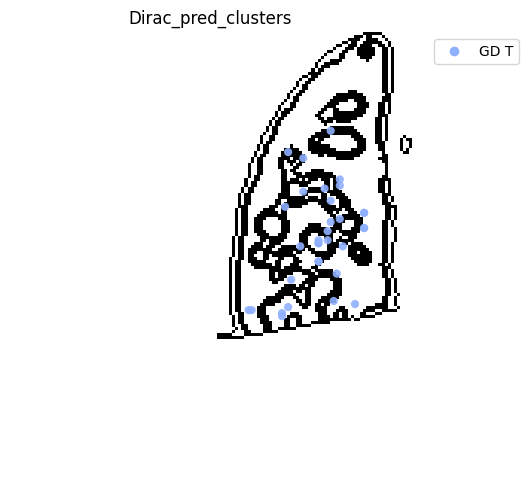

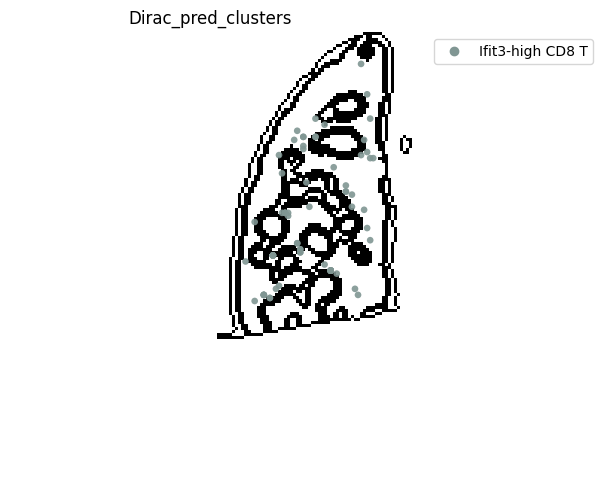

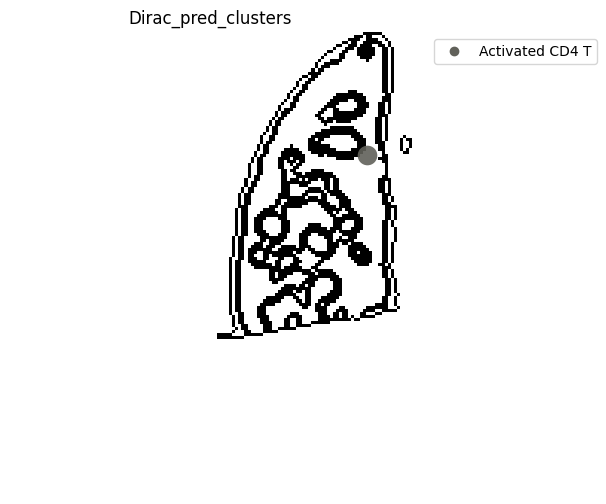

In [48]:
target_adata_total.obsm['spatial_bin100'] = target_adata_total.obsm['spatial'] // 100

target_adata_total = st.io.read_image(
    target_adata_total,
    filename=os.path.join("/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/mouse_spleen/Results/B05050G1_bin100_Dirac/20241206164031", "spatial_domains.png"),
    img_layer="layer1",
    slice="slice1",
    scale_factor=1,
)
target_adata_total.uns["__type"] = "UMI"

fig, ax = plt.subplots(figsize=(8, 6))
st.pl.space(
    target_adata_total,
    space="spatial_bin100",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    # figsize=(5, 3),
    show_legend="upper left",
    img_layers = "layer1",
    slices="slice1",
    # dpi=300, 
    pointsize=0.2,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(total_save_path, f"{data_name}_{methods}_cell_type_outlines.png"), dpi = 600)

save_fig_path = os.path.join(total_save_path, "Single_cell_type_outline")
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)

for i in target_adata_total.obs[f"{methods}_pred_clusters"].unique():
    fig, ax = plt.subplots(figsize=(8, 6))
    st.pl.space(
        target_adata_total[target_adata_total.obs[f"{methods}_pred_clusters"].isin([i])],
        space = "spatial_bin100",
        color = ["Dirac_pred_clusters"],
        alpha = 0.9,
        figsize = (5, 3),
        show_legend = "upper left",
        img_layers = "layer1",
        slices="slice1",
        dpi=300, 
        pointsize=0.05,
        color_key = colormaps_clusters,
        ax=ax)
    fig.savefig(os.path.join(save_fig_path, f"{data_name}_{i}.png"), dpi = 600)

# ######### save data
target_adata_total.write(os.path.join(total_save_path, f"{data_name}_{methods}_{use_counts}_target.h5ad"), compression="gzip")
source_adata_total.write(os.path.join(total_save_path, f"{data_name}_{methods}_{use_counts}_source.h5ad"), compression="gzip")

        domain       celltype  count
0  B cell zone           B1 B     47
1  B cell zone   CD122+ CD8 T     45
2  B cell zone          CD4 T     86
3  B cell zone          CD8 T     58
4  B cell zone   Ifit3-high B    174
5  B cell zone  Ly6-high mono     23
6  B cell zone           MZ B   3933
7  B cell zone       Mature B  16302
8  B cell zone             NK      3
9  B cell zone            NKT     10


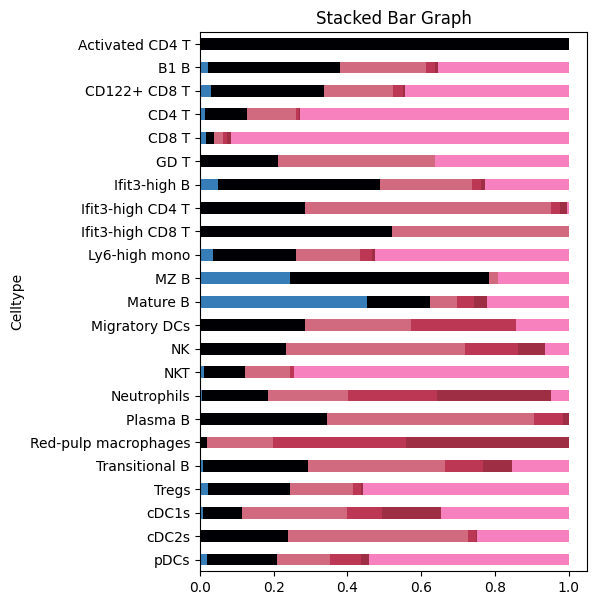

In [84]:
############## downstream at bin=50
# Summary domain-cell relationship
bin50_cluster2colors = {
    "Marginal zone": '#000004ff',
    "Capsule": '#57106eff',
    "T cell zone": "#F781BF",
    "B cell zone": "#377EB8",
    "Red pulp 1":'#d16a7fff',
    "Red pulp 2":'#bc3754ff',
    "Red pulp 3":'#9e2e44ff',
}
domain_list = np.array([])
celltype_list = np.array([])
count_list = np.array([])
for i in np.unique(target_adata_RNA.obs["region_domain_from_bin50"]):
    tmp, counts = np.unique(target_adata_total[target_adata_RNA.obs["region_domain_from_bin50"] == i,:].obs[f"{methods}_pred_clusters"], return_counts=True)
    domain_list = np.append(domain_list, np.repeat(i, len(counts)))
    celltype_list = np.append(celltype_list, tmp)
    count_list = np.append(count_list, counts)
hetero_df = pd.DataFrame({"domain":domain_list, "celltype":celltype_list, "count":count_list.astype(int)})

print(hetero_df[0:10])

# Cell distribution among domains
spec_df_plt = hetero_df.pivot(index="celltype", columns="domain", values="count").fillna(0)
spec_df_plt = spec_df_plt.div(spec_df_plt.sum(axis=1), axis=0)

spec_df_plt['Celltype'] = spec_df_plt.index
spec_df_plt.index = pd.CategoricalIndex(spec_df_plt.index, categories=spec_df_plt.index.astype(str).sort_values())
spec_df_plt = spec_df_plt.sort_index(ascending=False)


ax = spec_df_plt.plot(
    x = 'Celltype',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True,
    figsize=(5, 7),
    legend = False,
    color = bin50_cluster2colors,
)

# Save the plot
plt.savefig(os.path.join(total_save_path, f"{data_name}_bin100_celltype_distribution.pdf"), dpi = 600)
plt.show()

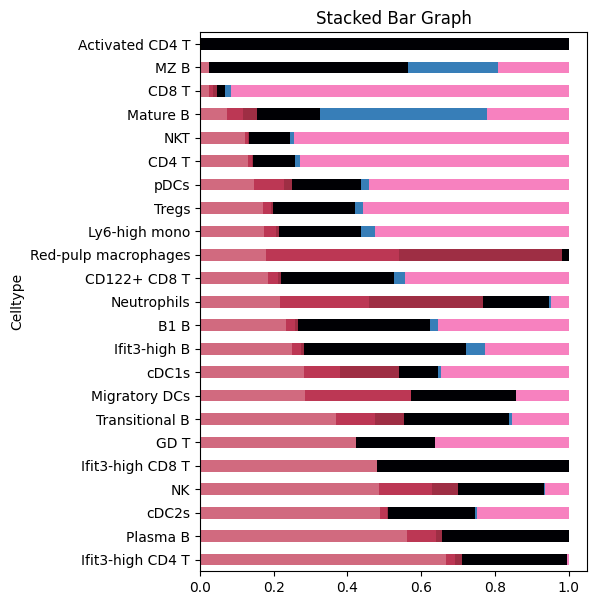

In [85]:
##### In bin50, calculate cell type proportions.
desired_order = ["Red pulp 1", "Red pulp 2", "Red pulp 3", "Marginal zone", "B cell zone", "T cell zone"]

# Rearrange the columns based on the desired region order (temporarily excluding 'Celltype')
spec_df_plt = spec_df_plt[desired_order + ['Celltype']]

# Create a new DataFrame to store the sorted data
sorted_spec_df_plt = pd.DataFrame()

# For each region, sort the cell types by proportion in descending order
for region in desired_order:
    # Sort the cell types for the current region
    region_df = spec_df_plt.sort_values(by=region, ascending=False)
    sorted_spec_df_plt = pd.concat([sorted_spec_df_plt, region_df])

# Remove duplicates while preserving the order (keeping the first occurrence)
sorted_spec_df_plt = sorted_spec_df_plt.drop_duplicates(subset=['Celltype'], keep='first')

# Reset the index to ensure the bar chart order is correct
sorted_spec_df_plt.index = pd.CategoricalIndex(sorted_spec_df_plt['Celltype'], categories=sorted_spec_df_plt['Celltype'], ordered=True)

# Rearrange the columns to maintain the desired region order along with 'Celltype'
sorted_spec_df_plt = sorted_spec_df_plt[desired_order + ['Celltype']]

# Plot the stacked horizontal bar chart
ax = sorted_spec_df_plt.plot(
    x='Celltype',
    kind='barh',
    stacked=True,
    title='Stacked Bar Graph',
    mark_right=True,
    figsize=(5, 7),
    legend=False,
    color=bin50_cluster2colors,
)

# Save the figure
plt.savefig(os.path.join(total_save_path, f"{data_name}_bin100_celltype_distribution_sorted.pdf"), dpi=600)
plt.show()

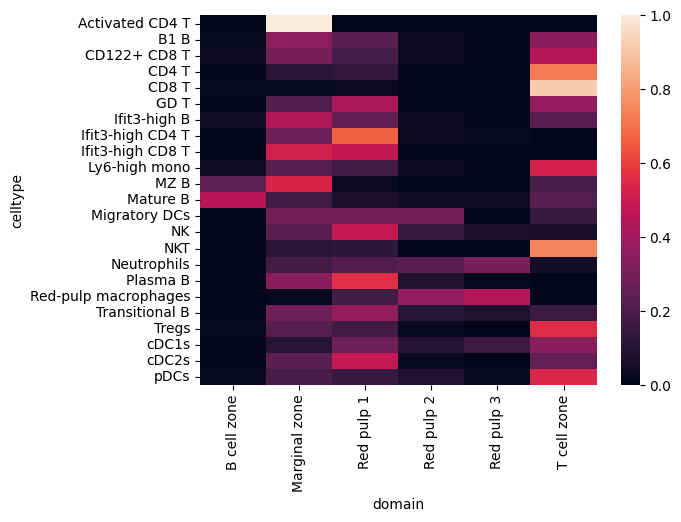

In [86]:
# Cell composition within each domain
import seaborn as sns
hetero_df_plt = hetero_df[hetero_df.domain!="NA"].pivot(index="domain", columns="celltype", values="count").fillna(0)
hetero_df_plt = hetero_df_plt.div(hetero_df_plt.sum(axis=0), axis=1)

ax = sns.heatmap(hetero_df_plt.T)
plt.savefig(os.path.join(total_save_path, f"{data_name}_bin100_celltype_heatmap.pdf"), dpi = 600)
plt.show()

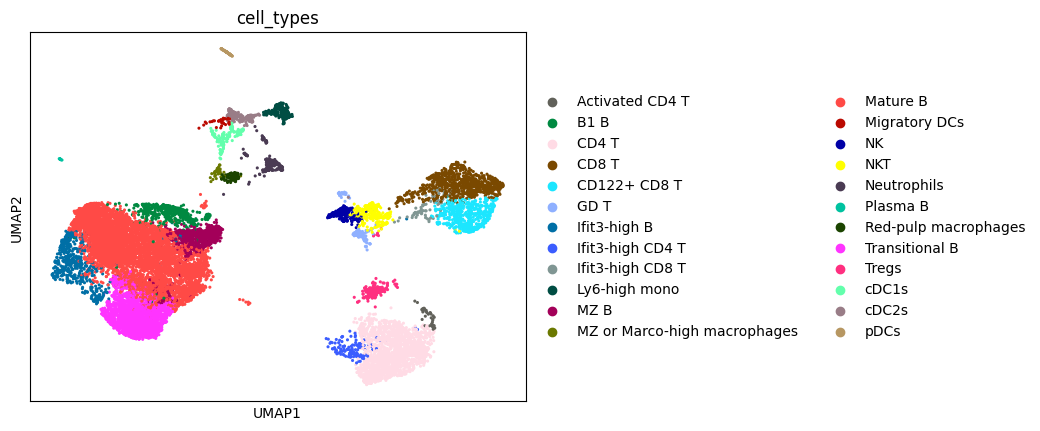

In [38]:
dp = sc.pl.umap(source_adata_RNA,color = "cell_types", palette = colormaps_clusters, size=20, return_fig=True)
dp.savefig(os.path.join(save_path, "cite_seq_annotation.pdf"), bbox_inches='tight', dpi = 300)

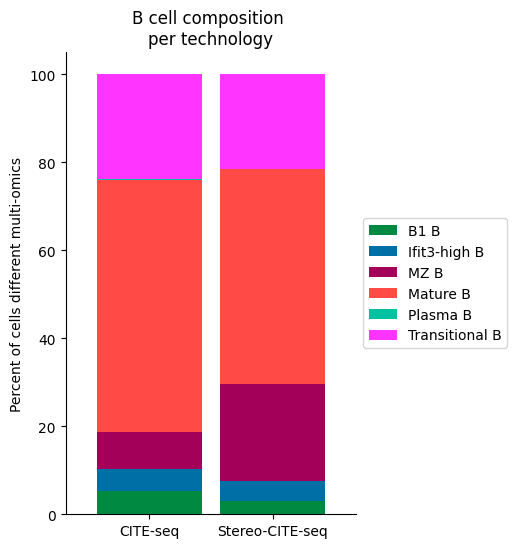

In [87]:
############
# Use this ordering of cell types for consistency
import seaborn as sns

Bcell_clust_onevall = ['Plasma B', 'Transitional B', 'Mature B', 'Ifit3-high B', 'B1 B', 'MZ B']

# Plot composition of spleen and lymph node B cell subsets as a stacked bar chart

# Calculate cluster composition of each tissue
# Get spleen/LN cells
source_spleen_B = source_adata_total[source_adata_total.obs["cell_types"].isin(Bcell_clust_onevall)]
target_spleen_B = target_adata_total[target_adata_total.obs["Dirac_pred_clusters"].isin(Bcell_clust_onevall)]


# Get cluster labels
source_spleen_clusters = pd.Series(source_spleen_B.obs["cell_types"].values)
target_spleen_clusters = pd.Series(target_spleen_B.obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp  = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp = target_spleen_clusters.value_counts()/np.sum(target_spleen_clusters.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, "Stereo-CITE-seq": target_spleen_comp}))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("B cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(total_save_path,"Bcell_composition_per_tissue.pdf"), dpi=300, bbox_inches='tight')

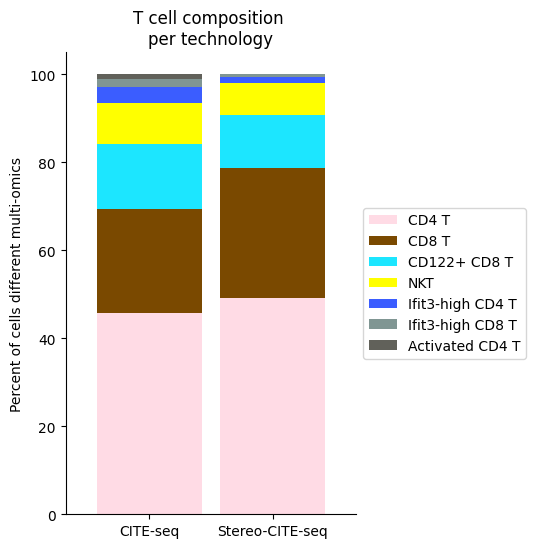

In [88]:
############
# Use this ordering of cell types for consistency
import seaborn as sns

Tcell_clust_onevall = ['Ifit3-high CD4 T','CD4 T', 'CD8 T', 'CD122+ CD8 T', 'Ifit3-high CD8 T', 'Activated CD4 T','NKT']

# Plot composition of spleen and lymph node B cell subsets as a stacked bar chart

# Calculate cluster composition of each tissue
# Get spleen/LN cells
source_spleen_T = source_adata_total[source_adata_total.obs["cell_types"].isin(Tcell_clust_onevall)]
target_spleen_T = target_adata_total[target_adata_total.obs["Dirac_pred_clusters"].isin(Tcell_clust_onevall)]


# Get cluster labels
source_spleen_clusters = pd.Series(source_spleen_T.obs["cell_types"].values)
target_spleen_clusters = pd.Series(target_spleen_T.obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp  = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp = target_spleen_clusters.value_counts()/np.sum(target_spleen_clusters.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, "Stereo-CITE-seq": target_spleen_comp}))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("T cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(total_save_path,"Tcell_composition_per_tissue.pdf"), dpi=300, bbox_inches='tight')

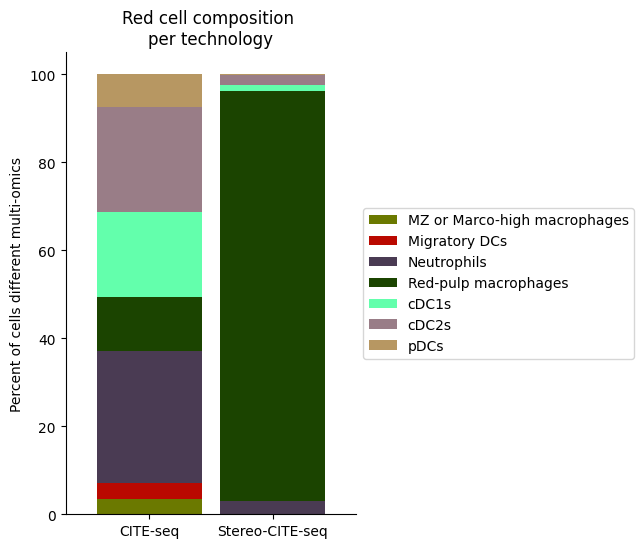

In [89]:
############
# Use this ordering of cell types for consistency
import seaborn as sns

Rcell_clust_onevall = ['Red-pulp macrophages', 'Migratory DCs', 'pDCs', 'cDC1s', 'cDC2s','Neutrophils', 'MZ or Marco-high macrophages']

# Plot composition of spleen and lymph node B cell subsets as a stacked bar chart

# Calculate cluster composition of each tissue
# Get spleen/LN cells
source_spleen_R = source_adata_total[source_adata_total.obs["cell_types"].isin(Rcell_clust_onevall)]
target_spleen_R = target_adata_total[target_adata_total.obs["Dirac_pred_clusters"].isin(Rcell_clust_onevall)]


# Get cluster labels
source_spleen_clusters = pd.Series(source_spleen_R.obs["cell_types"].values)
target_spleen_clusters = pd.Series(target_spleen_R.obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp  = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp = target_spleen_clusters.value_counts()/np.sum(target_spleen_clusters.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, "Stereo-CITE-seq": target_spleen_comp}))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("Red cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(total_save_path,"Rcell_composition_per_tissue.pdf"), dpi=300, bbox_inches='tight')

### Step 2.2: ADT only

In [42]:
use_counts = "Protein"
common_features = list(set(source_adata_protein.var_names) & (set(target_adata_protein.var_names)))
source_adata_protein = source_adata_protein[:,common_features].copy()
target_adata_protein = target_adata_protein[:,common_features].copy()

source_adata_protein.obs[f"{use_obs_name}_num"] = source_adata_protein.obs[f"{use_obs_name}"].astype('category').cat.codes

protein_save_path = os.path.join(save_path, f"{use_counts}")
if not os.path.exists(protein_save_path):
    os.makedirs(protein_save_path)

source_adata_protein.obs["batch"] = "Source"
target_adata_protein.obs["batch"] = "Target"
pairs = dict(set(zip(source_adata_protein.obs[f"{use_obs_name}_num"], source_adata_protein.obs[f"{use_obs_name}"])))
source_label = source_adata_protein.obs[f"{use_obs_name}_num"].values
source_regions = source_adata_protein.obs["batch"].values
target_regions = target_adata_protein.obs["batch"].values

sc.pp.normalize_total(source_adata_protein, target_sum=1e4)
sc.pp.log1p(source_adata_protein)
sc.pp.scale(source_adata_protein)

sc.pp.normalize_total(target_adata_protein, target_sum=1e4)
sc.pp.log1p(target_adata_protein)
sc.pp.scale(target_adata_protein)

source_adata_protein.obsm["X_HVG"] = source_adata_protein.X
target_adata_protein.obsm["X_HVG"] = target_adata_protein.X

source_adata_protein.obsm["X_HVG"] = source_adata_protein.obsm["X_HVG"].astype("float32")
target_adata_protein.obsm["X_HVG"] = target_adata_protein.obsm["X_HVG"].astype("float32")

In [43]:
source_edge_index = sd.utils.get_multi_edge_index(source_adata_protein.X.copy(), source_adata_protein.obs[f"{use_obs_name}"].copy().to_numpy(), n_neighbors = 8)
source_edge_index = torch.LongTensor(source_edge_index).T
target_adata_protein.obsm['spatial'] = target_adata_protein.obsm['spatial'].astype("float32")
target_edge_index = sd.utils.get_single_edge_index(target_adata_protein.obsm["spatial"].copy(), n_neighbors = 8)
target_edge_index = torch.LongTensor(target_edge_index).T

In [44]:
# Clear GPU memory
torch.cuda.empty_cache()
semisuper = sd.main.annotate_app(save_path = protein_save_path, use_gpu=True)
samples = semisuper._get_data(
                source_data = source_adata_protein.obsm["X_HVG"].copy(),
                source_label = source_label,
                source_edge_index = source_edge_index,
                target_data = target_adata_protein.obsm["X_HVG"].copy(),
                target_edge_index = target_edge_index,
                source_domain = np.zeros(source_adata_protein.shape[0]),
                target_domain = np.ones(target_adata_protein.shape[0]),
                num_parts_source = source_adata_total.shape[0] // 256,
                num_parts_target = target_adata_total.shape[0] // 512,
                weighted_classes = False,)

models = semisuper._get_model(samples=samples, opt_GNN = "SAGE")
results = semisuper._train_dirac_annotate(samples=samples, models=models, n_epochs=50)
np.save(os.path.join(save_path, f"{data_name}_{methods}_Results.npy"), results)

Found 2 unique domains.


Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
Dirac annotate training..: 100%|█| 50/50 [00:55<00:00,


Counter({'Mature B': 39785, 'B1 B': 27411, 'NKT': 17401, 'Transitional B': 13263, 'MZ B': 8307, 'CD4 T': 7043, 'CD8 T': 2432, 'Neutrophils': 1570, 'CD122+ CD8 T': 1149, 'cDC2s': 632, 'Tregs': 499, 'cDC1s': 247, 'GD T': 133, 'Ly6-high mono': 76, 'NK': 64, 'MZ or Marco-high macrophages': 37, 'Ifit3-high CD4 T': 17, 'pDCs': 16, 'Red-pulp macrophages': 15, 'Activated CD4 T': 13, 'Ifit3-high CD8 T': 4, 'Migratory DCs': 2, 'Ifit3-high B': 1})


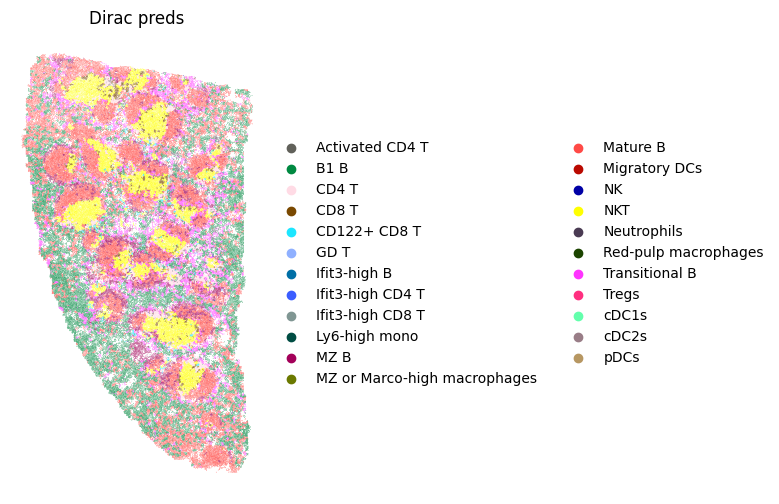

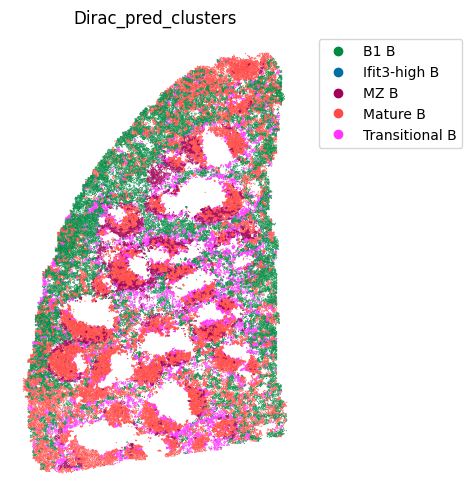

<Figure size 640x480 with 0 Axes>

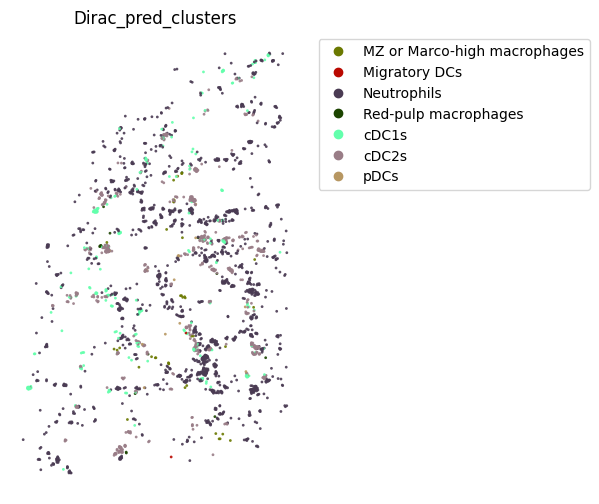

<Figure size 640x480 with 0 Axes>

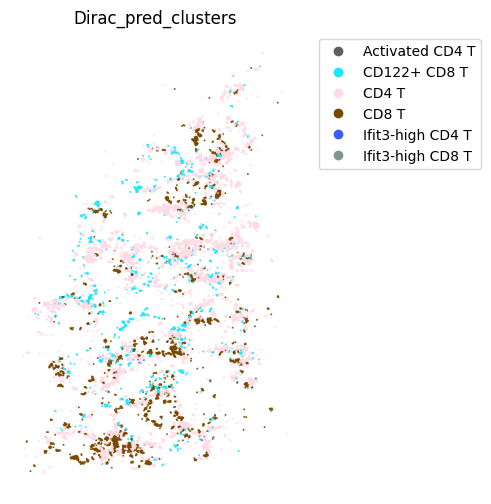

<Figure size 640x480 with 0 Axes>

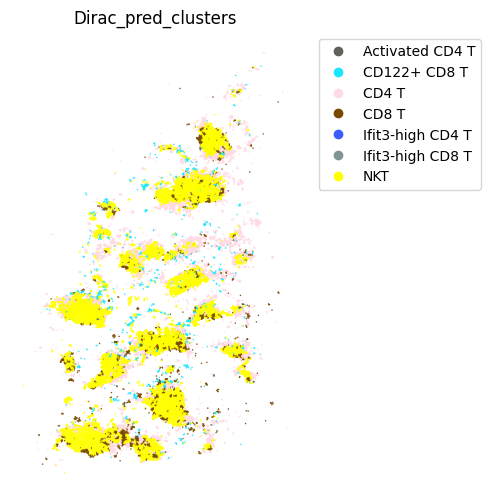

<Figure size 640x480 with 0 Axes>

In [45]:
source_adata_protein.obsm[f"{methods}_embed"] = results["source_feat"]
target_adata_protein.obsm[f"{methods}_embed"] = results["target_feat"]
target_adata_protein.obs[f"{methods}_confs"] = results["target_confs"]
target_adata_protein.obs[f"{methods}_pred_num"] = results["target_pred"]
target_adata_protein.obs[f"{methods}_pred_clusters"] = target_adata_protein.obs[f"{methods}_pred_num"].map(pairs)
print(Counter(target_adata_protein.obs[f"{methods}_pred_clusters"]))

fig, ax = plt.subplots(figsize=(8, 6))

sc.pl.spatial(target_adata_protein, 
              color=[f"{methods}_pred_clusters"], 
              frameon=False, 
              spot_size=15, 
              title=["Dirac preds"], 
              palette = colormaps_clusters,
                img_key = None,
              ax=ax)
fig.savefig(os.path.join(protein_save_path, f"{data_name}_cell_type.pdf"), bbox_inches='tight', dpi = 300)

target_adata_protein.uns['__type'] = "UMI"
fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_protein[target_adata_protein.obs[f"{methods}_pred_clusters"].isin(['Transitional B', 'Mature B', 'Plasma B',
                                                                                'Ifit3-high B', 'B1 B', 'MZ B'])], #, 'Erythrocytes'
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.05,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(protein_save_path, f"{data_name}_{methods}_B_spateo.png"), dpi = 600)


fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_protein[target_adata_protein.obs[f"{methods}_pred_clusters"].isin(['Red-pulp macrophages', 'Migratory DCs', 'pDCs', 
                                                        'cDC1s', 'cDC2s','Neutrophils', 'MZ or Marco-high macrophages'])], #, 
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.05,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(protein_save_path, f"{data_name}_{methods}_Red_pulp_spateo.png"), dpi = 600)


fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_protein[target_adata_protein.obs[f"{methods}_pred_clusters"].isin(['Activated CD4 T', 'Ifit3-high CD4 T','CD4 T', 'CD8 T', 
                                                                                'CD122+ CD8 T', 'Ifit3-high CD8 T'])], #, 
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.05,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(protein_save_path, f"{data_name}_{methods}_T_spateo.png"), dpi = 600)


fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_protein[target_adata_protein.obs[f"{methods}_pred_clusters"].isin(['Activated CD4 T', 'Ifit3-high CD4 T','CD4 T', 'CD8 T', 
                                                                                'CD122+ CD8 T', 'Ifit3-high CD8 T', 'NKT'])], #, 
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.05,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(protein_save_path, f"{data_name}_{methods}_T_NKT_spateo.png"), dpi = 600)



# save_fig_path = os.path.join(save_path, "Single_cell_type")
# if not os.path.exists(save_fig_path):
#     os.makedirs(save_fig_path)

# for i in target_adata_protein.obs[f"{methods}_pred_clusters"].unique():
#     fig, ax = plt.subplots(figsize=(8, 6))
#     sc.pl.spatial(target_adata_protein, 
#                   color=[f"{methods}_pred_clusters"], 
#                   groups=[i], 
#                   frameon=False, 
#                   spot_size=15, 
#                   title=["Dirac preds"], 
#                   palette = colormaps_clusters,
#                   ax=ax,
#                  )
#     fig.savefig(os.path.join(save_fig_path, f"{data_name}_{i}.pdf"), bbox_inches='tight', dpi = 300)

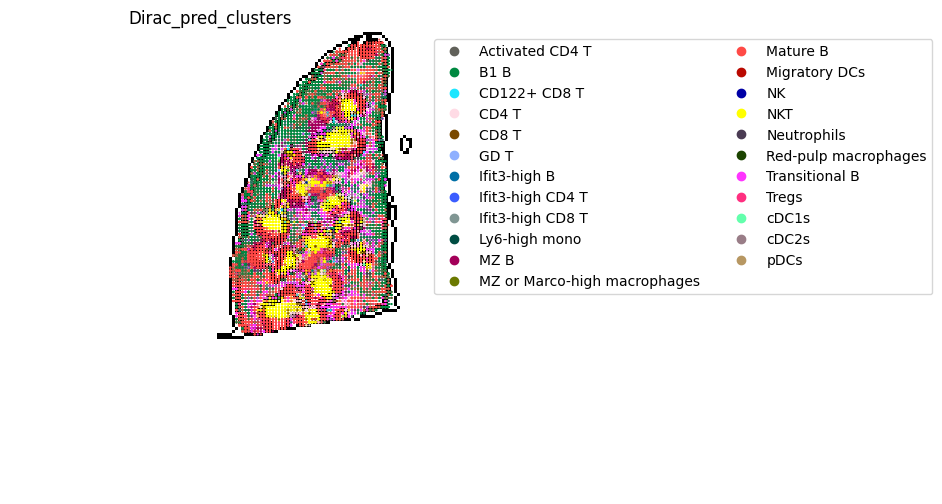

<Figure size 640x480 with 0 Axes>

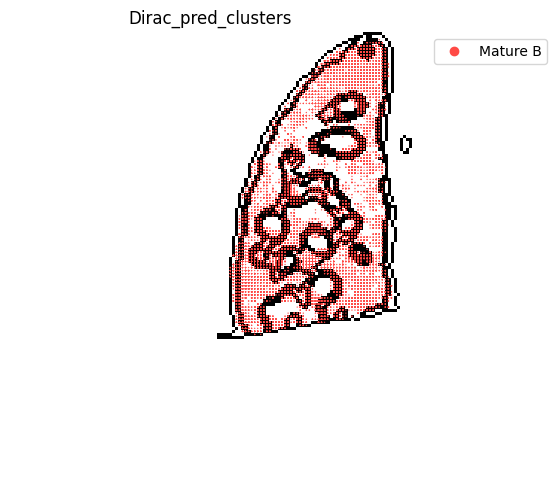

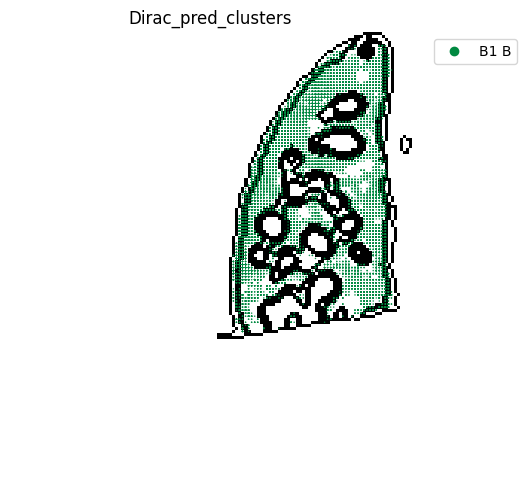

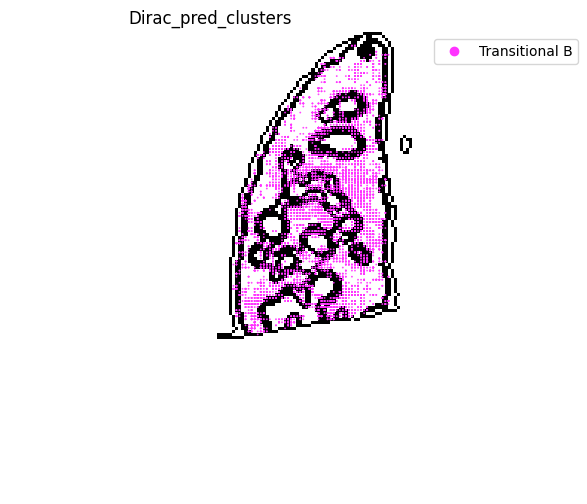

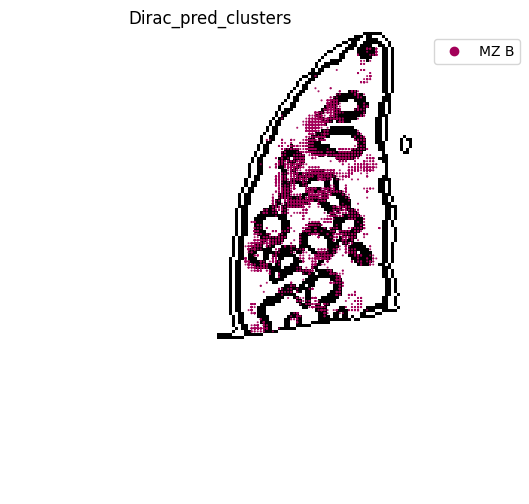

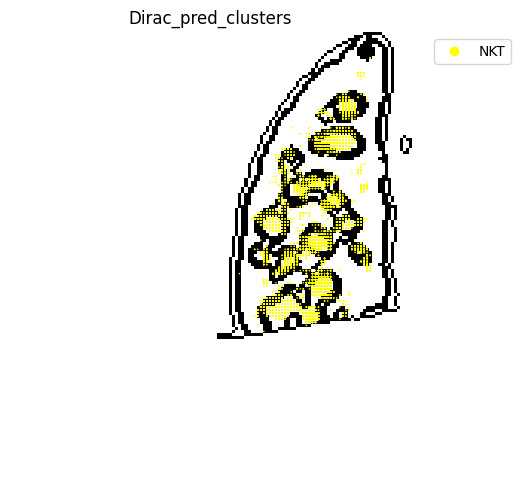

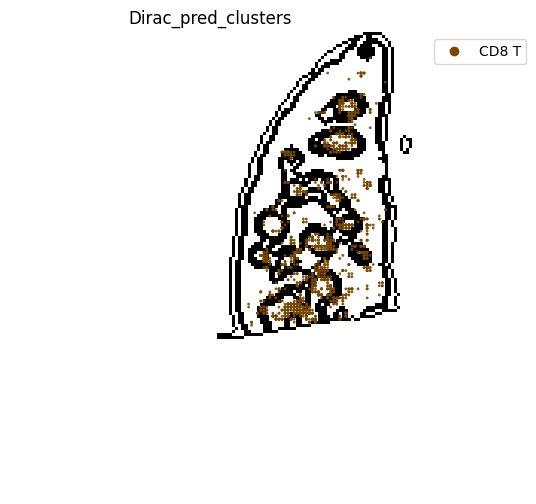

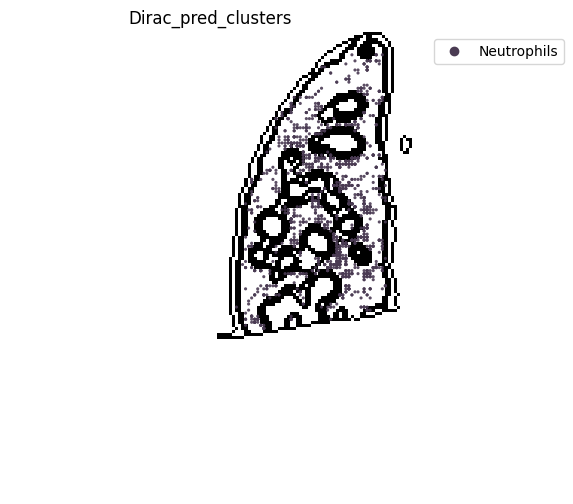

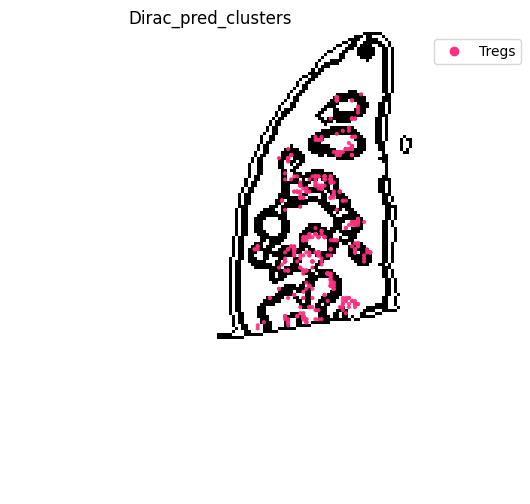

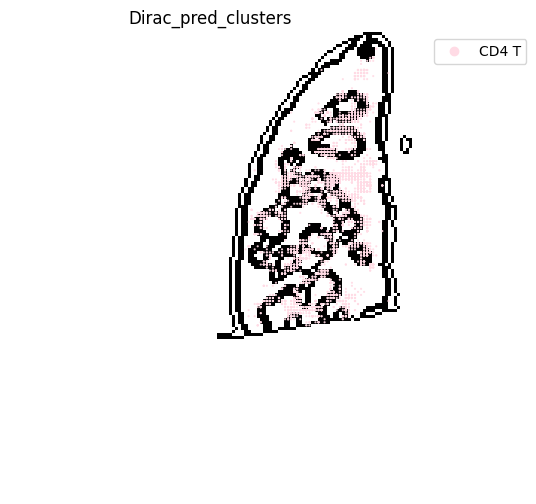

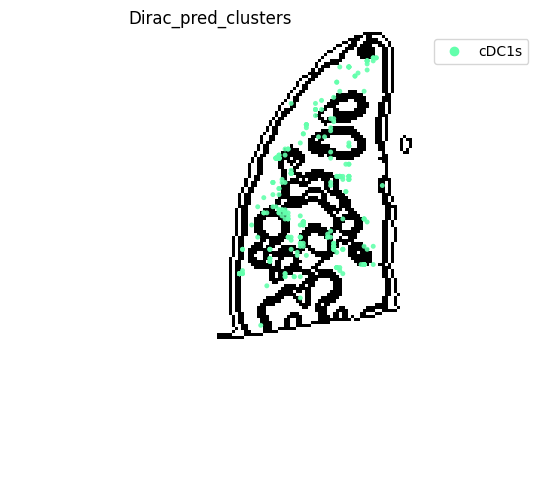

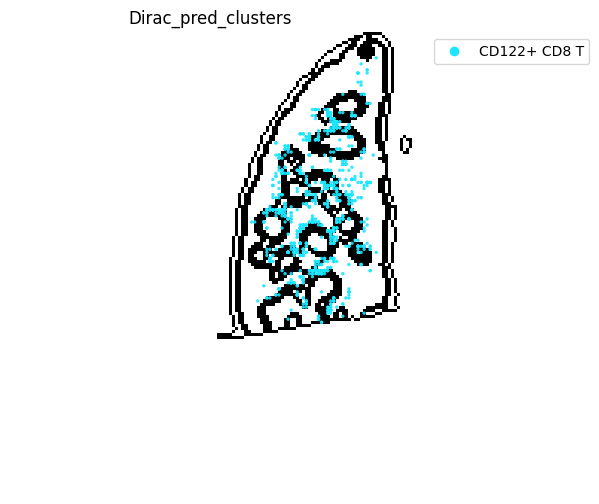

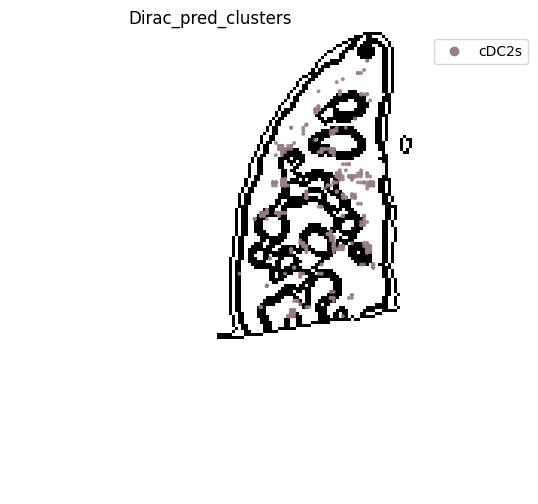

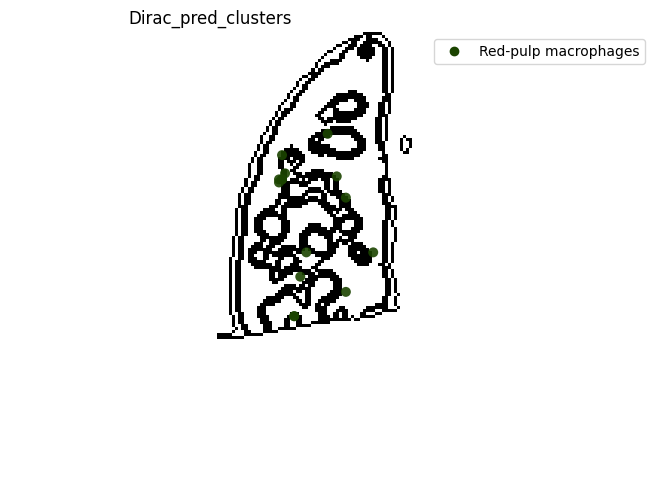

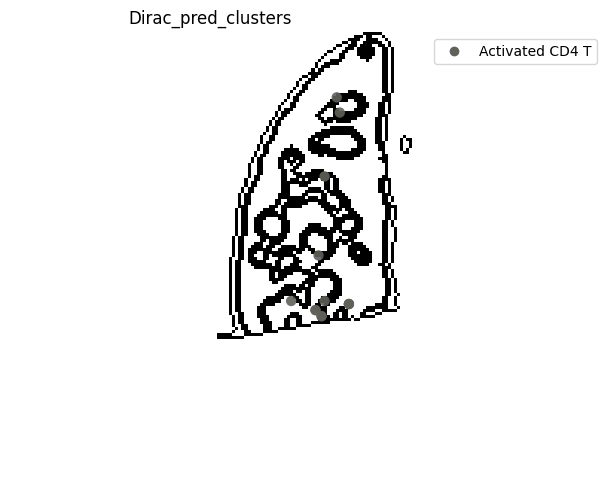

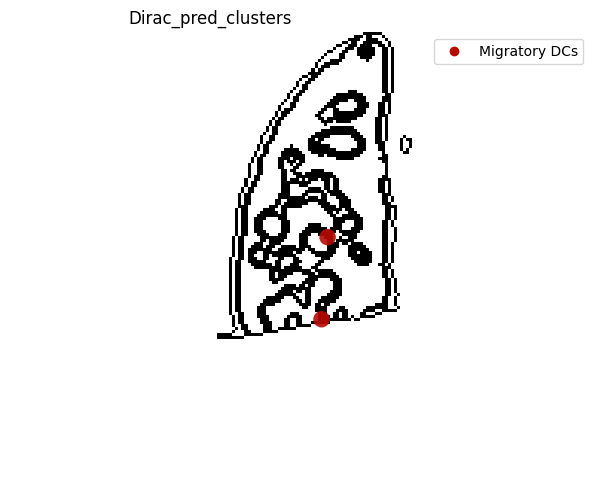

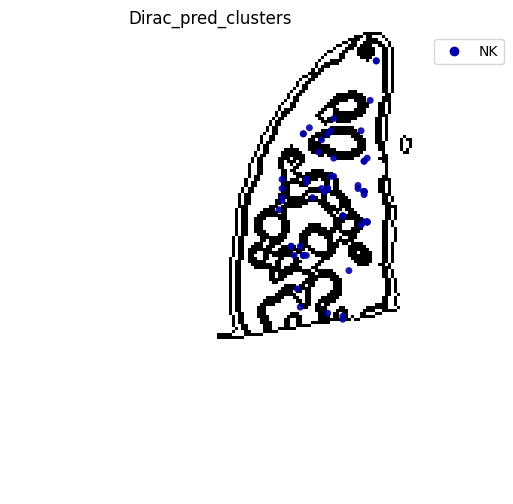

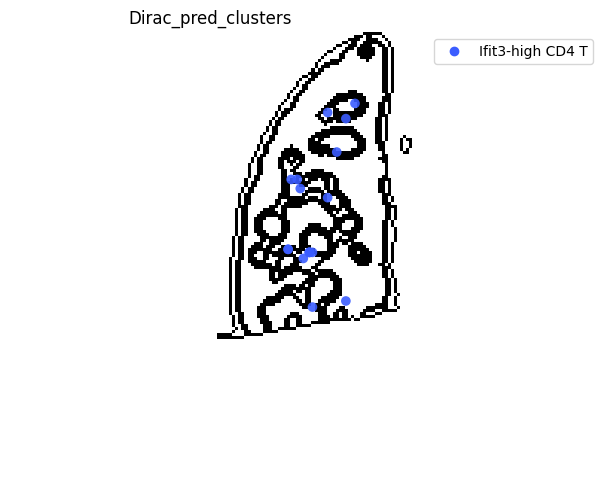

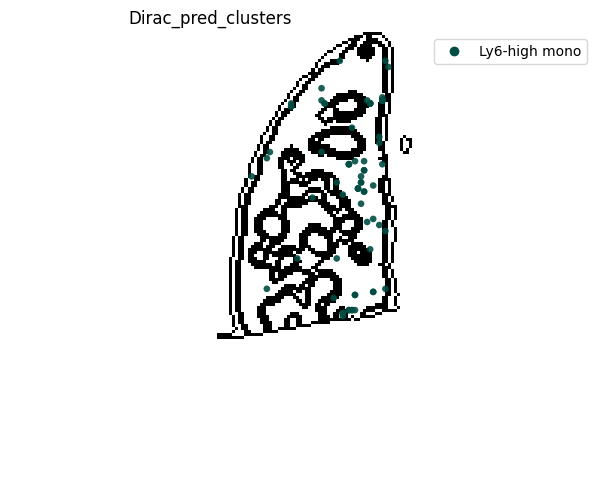

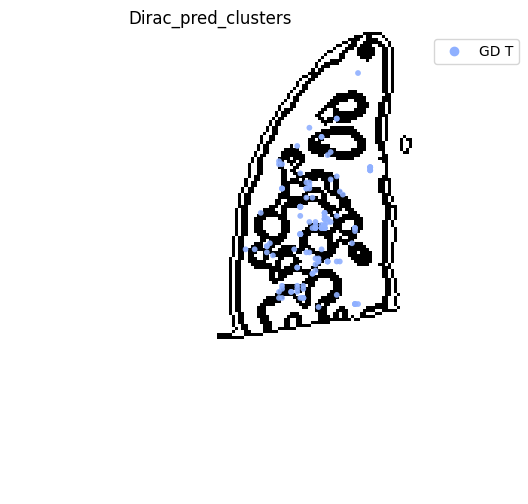

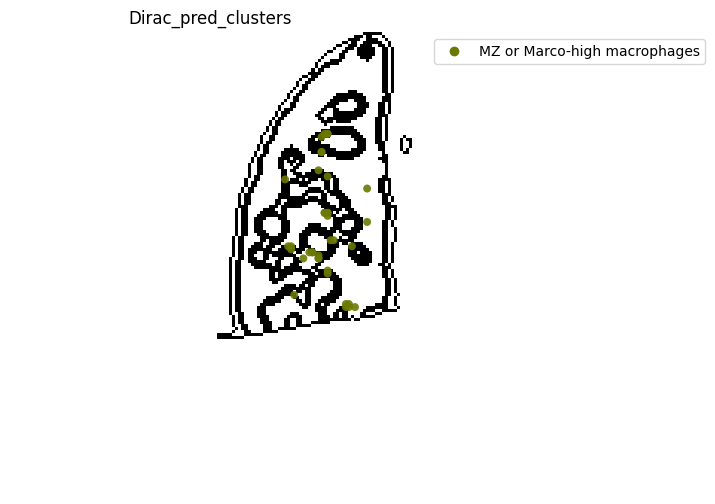

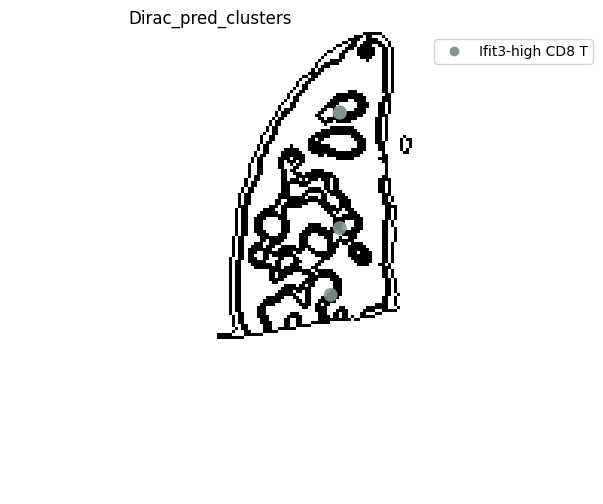

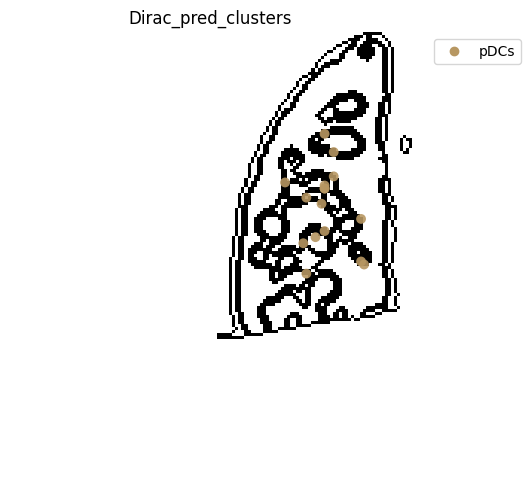

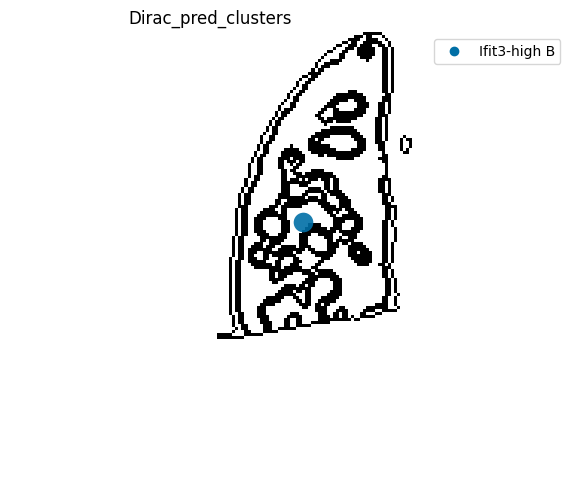

In [49]:
target_adata_protein.obsm['spatial_bin100'] = target_adata_protein.obsm['spatial'] // 100

target_adata_protein = st.io.read_image(
    target_adata_protein,
    filename=os.path.join("/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/mouse_spleen/Results/B05050G1_bin100_Dirac/20241206164031", "spatial_domains.png"),
    img_layer="layer1",
    slice="slice1",
    scale_factor=1,
)

target_adata_protein.uns["__type"] = "UMI"

fig, ax = plt.subplots(figsize=(8, 6))
st.pl.space(
    target_adata_protein,
    space="spatial_bin100",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(5, 3),
    show_legend="upper left",
    img_layers = "layer1",
    slices="slice1",
    dpi=300, 
    pointsize=0.2,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(protein_save_path, f"{data_name}_{methods}_cell_type_outlines.png"), dpi = 600)



save_fig_path = os.path.join(protein_save_path, "Single_cell_type_outline")
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)

for i in target_adata_protein.obs[f"{methods}_pred_clusters"].unique():
    fig, ax = plt.subplots(figsize=(8, 6))
    st.pl.space(
        target_adata_protein[target_adata_protein.obs[f"{methods}_pred_clusters"].isin([i])],
        space = "spatial_bin100",
        color = ["Dirac_pred_clusters"],
        alpha = 0.9,
        figsize = (5, 3),
        show_legend = "upper left",
        img_layers = "layer1",
        slices="slice1",
        dpi=300, 
        pointsize=0.05,
        color_key = colormaps_clusters,
        ax=ax)
    fig.savefig(os.path.join(save_fig_path, f"{data_name}_{i}.png"), dpi = 600)

######### save data
target_adata_protein.write(os.path.join(protein_save_path, f"{data_name}_{methods}_{use_counts}_target.h5ad"), compression="gzip")
source_adata_protein.write(os.path.join(protein_save_path, f"{data_name}_{methods}_{use_counts}_source.h5ad"), compression="gzip")

        domain                      celltype  count
0  B cell zone               Activated CD4 T      9
1  B cell zone                  CD122+ CD8 T     13
2  B cell zone                         CD4 T    474
3  B cell zone                         CD8 T    108
4  B cell zone                          GD T     14
5  B cell zone              Ifit3-high CD4 T      5
6  B cell zone              Ifit3-high CD8 T      2
7  B cell zone                          MZ B   2593
8  B cell zone  MZ or Marco-high macrophages      6
9  B cell zone                      Mature B  15143


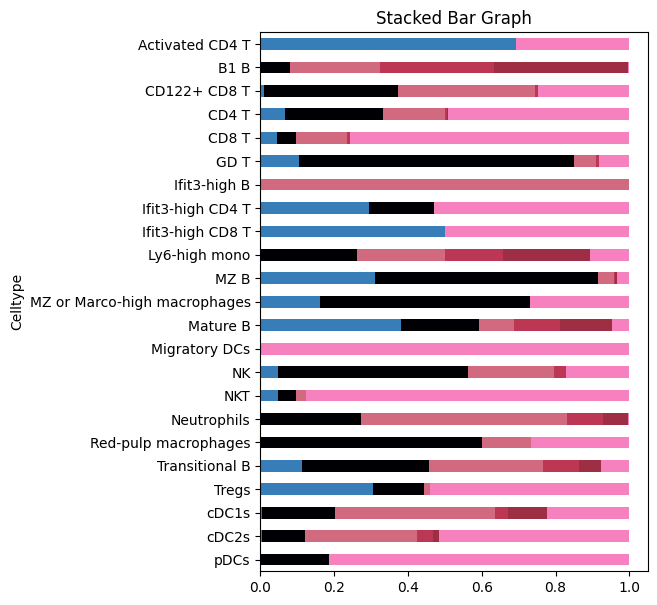

In [57]:
############## downstream at bin=100
# Summary domain-cell relationship
bin50_cluster2colors = {
    "Marginal zone": '#000004ff',
    "Capsule": '#57106eff',
    "T cell zone": "#F781BF",
    "B cell zone": "#377EB8",
    "Red pulp 1":'#d16a7fff',
    "Red pulp 2":'#bc3754ff',
    "Red pulp 3":'#9e2e44ff',
}

domain_list = np.array([])
celltype_list = np.array([])
count_list = np.array([])
for i in np.unique(target_adata_RNA.obs["region_domain_from_bin50"]):
    tmp, counts = np.unique(target_adata_protein[target_adata_RNA.obs["region_domain_from_bin50"] == i,:].obs[f"{methods}_pred_clusters"], return_counts=True)
    domain_list = np.append(domain_list, np.repeat(i, len(counts)))
    celltype_list = np.append(celltype_list, tmp)
    count_list = np.append(count_list, counts)
hetero_df = pd.DataFrame({"domain":domain_list, "celltype":celltype_list, "count":count_list.astype(int)})

print(hetero_df[0:10])

# Cell distribution among domains
spec_df_plt = hetero_df.pivot(index="celltype", columns="domain", values="count").fillna(0)
spec_df_plt = spec_df_plt.div(spec_df_plt.sum(axis=1), axis=0)

spec_df_plt['Celltype'] = spec_df_plt.index
spec_df_plt.index = pd.CategoricalIndex(spec_df_plt.index, categories=spec_df_plt.index.astype(str).sort_values())
spec_df_plt = spec_df_plt.sort_index(ascending=False)


ax = spec_df_plt.plot(
    x = 'Celltype',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True,
    figsize=(5, 7),
    legend = False,
    color = bin50_cluster2colors,
)

# Save the plot
plt.savefig(os.path.join(protein_save_path, f"{data_name}_bin100_celltype_distribution.pdf"), dpi = 600)
plt.show()

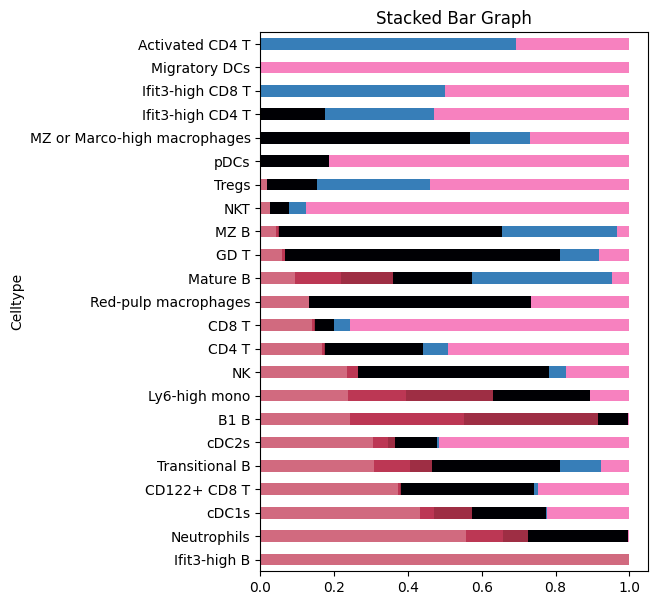

In [58]:
# Define the order of regions
desired_order = ["Red pulp 1", "Red pulp 2", "Red pulp 3", "Marginal zone", "B cell zone", "T cell zone"]

# Rearrange the columns based on the desired region order (temporarily excluding 'Celltype')
spec_df_plt = spec_df_plt[desired_order + ['Celltype']]

# Create a new DataFrame to store the sorted data
sorted_spec_df_plt = pd.DataFrame()

# Sort the cell types by proportion in descending order for each region
for region in desired_order:
    # Sort the cell types for the current region
    region_df = spec_df_plt.sort_values(by=region, ascending=False)
    sorted_spec_df_plt = pd.concat([sorted_spec_df_plt, region_df])

# Remove duplicates while preserving the order (keeping the first occurrence)
sorted_spec_df_plt = sorted_spec_df_plt.drop_duplicates(subset=['Celltype'], keep='first')

# Reset the index to ensure the order of the bar chart is correct
sorted_spec_df_plt.index = pd.CategoricalIndex(sorted_spec_df_plt['Celltype'], categories=sorted_spec_df_plt['Celltype'], ordered=True)

# Rearrange the columns to maintain the desired region order along with 'Celltype'
sorted_spec_df_plt = sorted_spec_df_plt[desired_order + ['Celltype']]

# Plot the stacked horizontal bar chart
ax = sorted_spec_df_plt.plot(
    x='Celltype',
    kind='barh',
    stacked=True,
    title='Stacked Bar Graph',
    mark_right=True,
    figsize=(5, 7),
    legend=False,
    color=bin50_cluster2colors,
)

# Save the figure
plt.savefig(os.path.join(protein_save_path, f"{data_name}_bin100_celltype_distribution.pdf"), dpi=600)
plt.show()

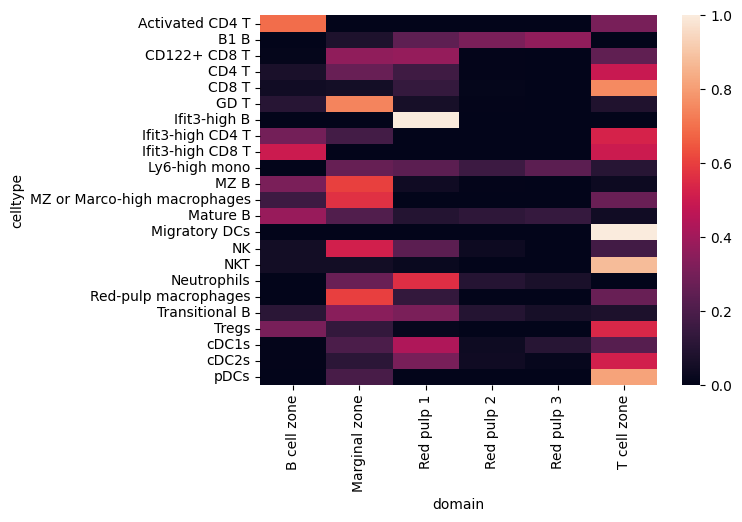

In [60]:
# Cell composition within each domain
import seaborn as sns
hetero_df_plt = hetero_df[hetero_df.domain!="NA"].pivot(index="domain", columns="celltype", values="count").fillna(0)
hetero_df_plt = hetero_df_plt.div(hetero_df_plt.sum(axis=0), axis=1)

ax = sns.heatmap(hetero_df_plt.T)
plt.savefig(os.path.join(protein_save_path, f"{data_name}_bin100_celltype_heatmap.pdf"), dpi = 600)
plt.show()

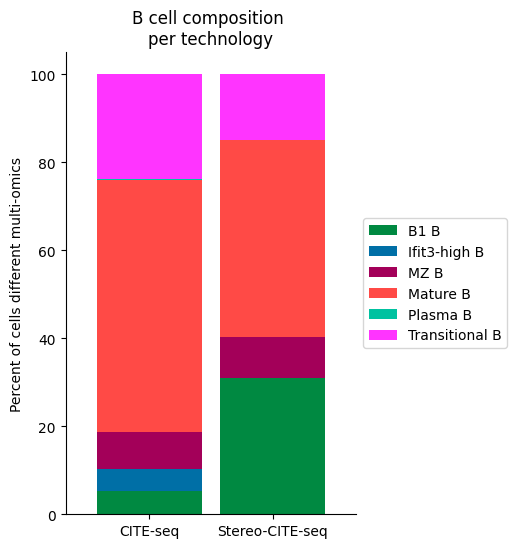

In [61]:
############
# Use this ordering of cell types for consistency
import seaborn as sns

Bcell_clust_onevall = ['Plasma B', 'Transitional B', 'Mature B', 'Ifit3-high B', 'B1 B', 'MZ B']

# Plot composition of spleen and lymph node B cell subsets as a stacked bar chart

# Calculate cluster composition of each tissue
# Get spleen/LN cells
source_spleen_B = source_adata_protein[source_adata_protein.obs["cell_types"].isin(Bcell_clust_onevall)]
target_spleen_B = target_adata_protein[target_adata_protein.obs["Dirac_pred_clusters"].isin(Bcell_clust_onevall)]


# Get cluster labels
source_spleen_clusters = pd.Series(source_spleen_B.obs["cell_types"].values)
target_spleen_clusters = pd.Series(target_spleen_B.obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp  = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp = target_spleen_clusters.value_counts()/np.sum(target_spleen_clusters.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, "Stereo-CITE-seq": target_spleen_comp}))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("B cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(protein_save_path,"Bcell_composition_per_tissue.pdf"), dpi=300, bbox_inches='tight')

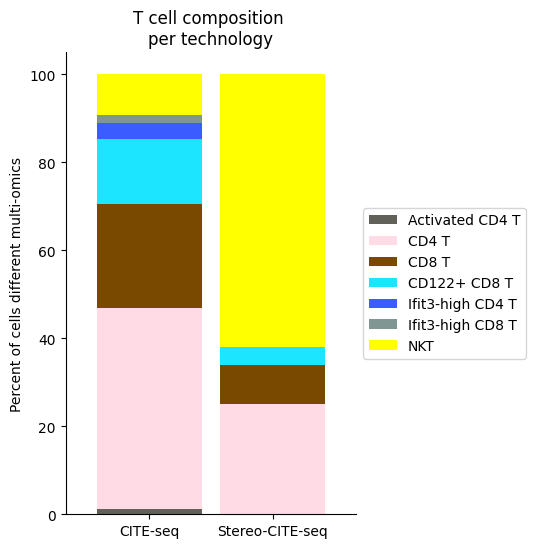

In [62]:
############
# Use this ordering of cell types for consistency
import seaborn as sns

Tcell_clust_onevall = ['Ifit3-high CD4 T','CD4 T', 'CD8 T', 'CD122+ CD8 T', 'Ifit3-high CD8 T', 'Activated CD4 T','NKT']

# Plot composition of spleen and lymph node B cell subsets as a stacked bar chart

# Calculate cluster composition of each tissue
# Get spleen/LN cells
source_spleen_T = source_adata_protein[source_adata_protein.obs["cell_types"].isin(Tcell_clust_onevall)]
target_spleen_T = target_adata_protein[target_adata_protein.obs["Dirac_pred_clusters"].isin(Tcell_clust_onevall)]


# Get cluster labels
source_spleen_clusters = pd.Series(source_spleen_T.obs["cell_types"].values)
target_spleen_clusters = pd.Series(target_spleen_T.obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp  = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp = target_spleen_clusters.value_counts()/np.sum(target_spleen_clusters.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, "Stereo-CITE-seq": target_spleen_comp}))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("T cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(protein_save_path,"Tcell_composition_per_tissue.pdf"), dpi=300, bbox_inches='tight')

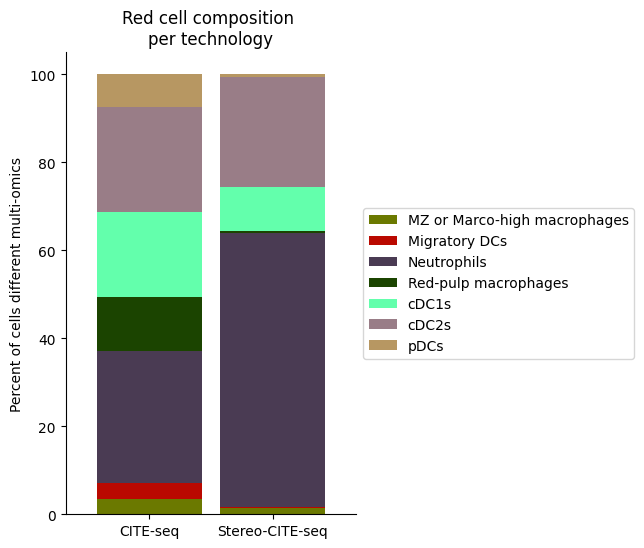

In [63]:
############
# Use this ordering of cell types for consistency
import seaborn as sns

Rcell_clust_onevall = ['Red-pulp macrophages', 'Migratory DCs', 'pDCs', 'cDC1s', 'cDC2s','Neutrophils', 'MZ or Marco-high macrophages']

# Plot composition of spleen and lymph node B cell subsets as a stacked bar chart

# Calculate cluster composition of each tissue
# Get spleen/LN cells
source_spleen_R = source_adata_protein[source_adata_protein.obs["cell_types"].isin(Rcell_clust_onevall)]
target_spleen_R = target_adata_protein[target_adata_protein.obs["Dirac_pred_clusters"].isin(Rcell_clust_onevall)]


# Get cluster labels
source_spleen_clusters = pd.Series(source_spleen_R.obs["cell_types"].values)
target_spleen_clusters = pd.Series(target_spleen_R.obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp  = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp = target_spleen_clusters.value_counts()/np.sum(target_spleen_clusters.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, "Stereo-CITE-seq": target_spleen_comp}))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("Red cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(protein_save_path,"Rcell_composition_per_tissue.pdf"), dpi=300, bbox_inches='tight')

### Step 2.3: Only RNA

In [64]:
use_counts = "RNA"

common_genes = list(set(source_adata_RNA.var_names) & (set(target_adata_RNA.var_names)))
source_adata_RNA = source_adata_RNA[:,common_genes].copy()
target_adata_RNA = target_adata_RNA[:,common_genes].copy()

source_adata_RNA.obs[f"{use_obs_name}_num"] = source_adata_RNA.obs[f"{use_obs_name}"].astype('category').cat.codes


RNA_save_path = os.path.join(save_path, f"{use_counts}")
if not os.path.exists(RNA_save_path):
    os.makedirs(RNA_save_path)

source_adata_RNA.obs["batch"] = "Source"
target_adata_RNA.obs["batch"] = "Target"
pairs = dict(set(zip(source_adata_RNA.obs[f"{use_obs_name}_num"], source_adata_RNA.obs[f"{use_obs_name}"])))
source_label = source_adata_RNA.obs[f"{use_obs_name}_num"].values
source_regions = source_adata_RNA.obs["batch"].values
target_regions = target_adata_RNA.obs["batch"].values

sc.pp.normalize_total(source_adata_RNA, target_sum=1e4)
sc.pp.log1p(source_adata_RNA)
sc.pp.scale(source_adata_RNA)
sc.pp.pca(source_adata_RNA)

sc.pp.normalize_total(target_adata_RNA, target_sum=1e4)
sc.pp.log1p(target_adata_RNA)
sc.pp.scale(target_adata_RNA)

source_adata_RNA.obsm["X_HVG"] = source_adata_RNA.X
target_adata_RNA.obsm["X_HVG"] = target_adata_RNA.X

source_adata_RNA.obsm["X_HVG"] = source_adata_RNA.obsm["X_HVG"].astype("float32")
target_adata_RNA.obsm["X_HVG"] = target_adata_RNA.obsm["X_HVG"].astype("float32")

In [65]:
source_edge_index = sd.utils.get_multi_edge_index(source_adata_RNA.obsm["X_pca"].copy(), source_adata_RNA.obs[f"{use_obs_name}"].copy().to_numpy(), n_neighbors = 8)
source_edge_index = torch.LongTensor(source_edge_index).T
target_adata_RNA.obsm['spatial']  =  target_adata_RNA.obsm['spatial'].astype("float32")
target_edge_index = sd.utils.get_single_edge_index(target_adata_RNA.obsm["spatial"].copy(), n_neighbors = 8)
target_edge_index = torch.LongTensor(target_edge_index).T

In [66]:
# Clear GPU memory
torch.cuda.empty_cache()
semisuper = sd.main.annotate_app(save_path = RNA_save_path, use_gpu=True)
samples = semisuper._get_data(
                source_data = source_adata_RNA.obsm["X_HVG"].copy(),
                source_label = source_label,
                source_edge_index = source_edge_index,
                target_data = target_adata_RNA.obsm["X_HVG"].copy(),
                target_edge_index = target_edge_index,
                source_domain = np.zeros(source_adata_RNA.shape[0]),
                target_domain = np.ones(target_adata_RNA.shape[0]),
                num_parts_source = source_adata_total.shape[0] // 256,
                num_parts_target = target_adata_total.shape[0] // 512,
                weighted_classes = False,)

models = semisuper._get_model(samples=samples, opt_GNN = "SAGE")
results = semisuper._train_dirac_annotate(samples=samples, models=models, n_epochs=50)
np.save(os.path.join(save_path, f"{data_name}_{methods}_Results.npy"), results)

Found 2 unique domains.


Computing METIS partitioning...
Done!
Computing METIS partitioning...
Done!
Dirac annotate training..: 100%|█| 50/50 [00:57<00:00,


Counter({'Mature B': 43966, 'Transitional B': 21207, 'Neutrophils': 10243, 'MZ B': 8253, 'CD4 T': 7745, 'B1 B': 6197, 'CD8 T': 4101, 'Ifit3-high B': 3710, 'CD122+ CD8 T': 3347, 'NKT': 2626, 'NK': 2437, 'Red-pulp macrophages': 1050, 'Ly6-high mono': 1038, 'cDC2s': 963, 'cDC1s': 814, 'Tregs': 782, 'Ifit3-high CD4 T': 438, 'GD T': 395, 'Ifit3-high CD8 T': 265, 'pDCs': 193, 'Activated CD4 T': 168, 'MZ or Marco-high macrophages': 140, 'Plasma B': 25, 'Migratory DCs': 14})


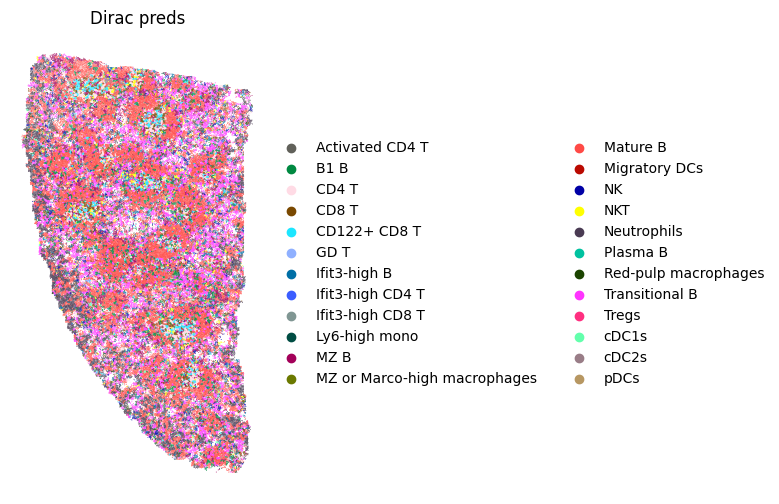

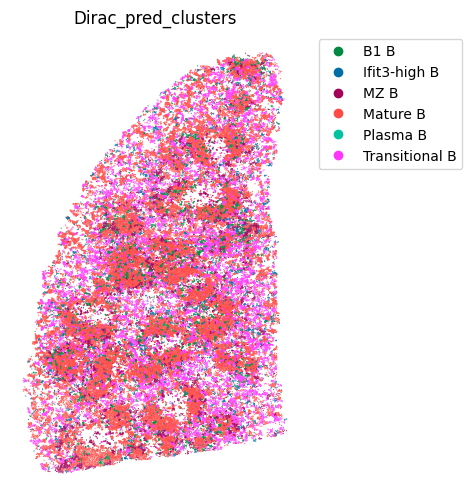

<Figure size 640x480 with 0 Axes>

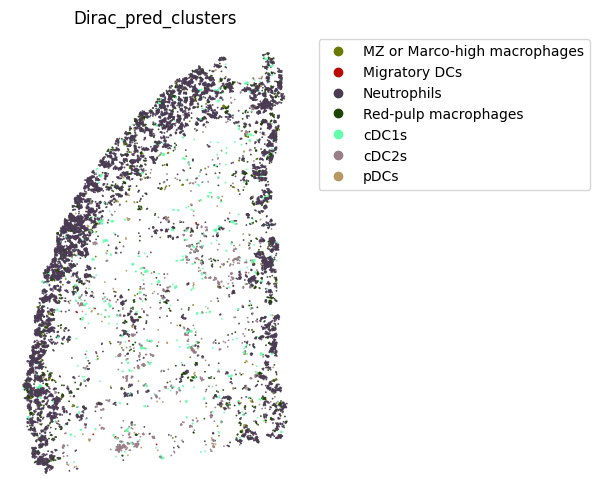

<Figure size 640x480 with 0 Axes>

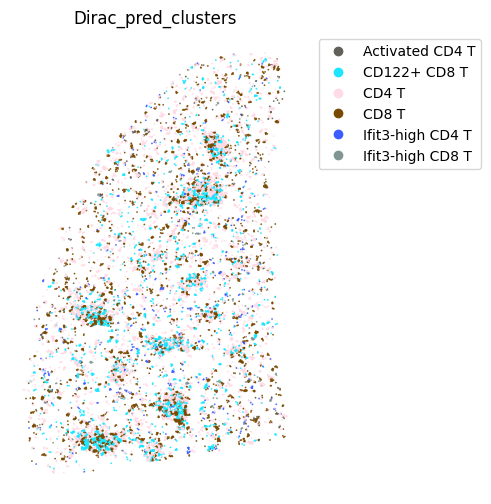

<Figure size 640x480 with 0 Axes>

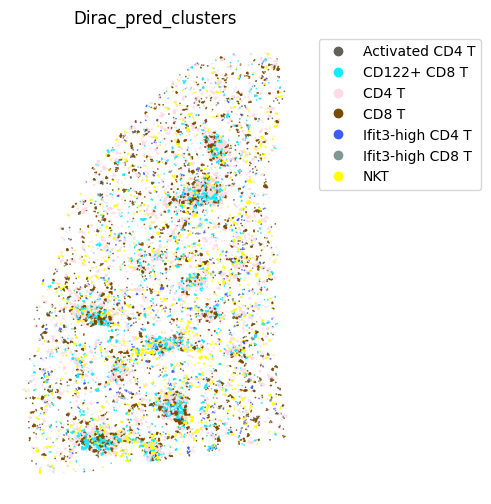

<Figure size 640x480 with 0 Axes>

In [68]:
source_adata_RNA.obsm[f"{methods}_embed"] = results["source_feat"]
target_adata_RNA.obsm[f"{methods}_embed"] = results["target_feat"]
target_adata_RNA.obs[f"{methods}_confs"] = results["target_confs"]
target_adata_RNA.obs[f"{methods}_pred_num"] = results["target_pred"]
target_adata_RNA.obs[f"{methods}_pred_clusters"] = target_adata_RNA.obs[f"{methods}_pred_num"].map(pairs)
print(Counter(target_adata_RNA.obs[f"{methods}_pred_clusters"]))

target_adata_RNA.obs[f"{methods}_pred_clusters"] = [names.replace('Cycling B/T cells', 'Cycling B or T cells') for names in target_adata_RNA.obs[f"{methods}_pred_clusters"]]
target_adata_RNA.obs[f"{methods}_pred_clusters"] = [names.replace('MZ/Marco-high macrophages', 'MZ or Marco-high macrophages') for names in target_adata_RNA.obs[f"{methods}_pred_clusters"]]


fig, ax = plt.subplots(figsize=(8, 6))

sc.pl.spatial(target_adata_RNA, 
              color=[f"{methods}_pred_clusters"], 
              frameon=False, 
              spot_size=20, 
              title=["Dirac preds"],
              img_key = None,
              palette = colormaps_clusters,
              ax=ax)
fig.savefig(os.path.join(RNA_save_path, f"{data_name}_cell_type.pdf"), bbox_inches='tight', dpi = 300)

target_adata_RNA.uns['__type'] = "UMI"
fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_RNA[target_adata_RNA.obs[f"{methods}_pred_clusters"].isin(['Transitional B', 'Mature B', 'Plasma B',
                                                                                'Ifit3-high B', 'B1 B', 'MZ B'])], #, 'Erythrocytes'
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.05,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(RNA_save_path, f"{data_name}_{methods}_B_spateo.png"), dpi = 600)


fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_RNA[target_adata_RNA.obs[f"{methods}_pred_clusters"].isin(['Red-pulp macrophages', 'Migratory DCs', 'pDCs', 
                                                        'cDC1s', 'cDC2s','Neutrophils', 'MZ or Marco-high macrophages'])], #, 
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.05,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(RNA_save_path, f"{data_name}_{methods}_Red_pulp_spateo.png"), dpi = 600)


fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_RNA[target_adata_RNA.obs[f"{methods}_pred_clusters"].isin(['Activated CD4 T', 'Ifit3-high CD4 T','CD4 T', 'CD8 T', 
                                                                                'CD122+ CD8 T', 'Ifit3-high CD8 T'])], #, 
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.05,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(RNA_save_path, f"{data_name}_{methods}_T_spateo.png"), dpi = 600)

fig, ax = plt.subplots(figsize=(4, 6))
st.pl.space(
    target_adata_RNA[target_adata_RNA.obs[f"{methods}_pred_clusters"].isin(['Activated CD4 T', 'Ifit3-high CD4 T','CD4 T', 'CD8 T', 
                                                                                'CD122+ CD8 T', 'Ifit3-high CD8 T', 'NKT'])], #, 
    space="spatial",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(8, 8),
    show_legend="upper left",
    dpi=300, 
    pointsize=0.05,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(RNA_save_path, f"{data_name}_{methods}_T_NKT_spateo.png"), dpi = 600)

# save_fig_path = os.path.join(save_path, "Single_cell_type")
# if not os.path.exists(save_fig_path):
#     os.makedirs(save_fig_path)

# for i in target_adata_RNA.obs[f"{methods}_pred_clusters"].unique():
#     fig, ax = plt.subplots(figsize=(8, 6))
#     sc.pl.spatial(target_adata_RNA, 
#                   color=[f"{methods}_pred_clusters"], 
#                   groups=[i], 
#                   frameon=False, 
#                   spot_size=20, 
#                   title=["Dirac preds"], 
#                   palette = colormaps_clusters,
#                   img_key = None,
#                   ax=ax,
#                  )
#     fig.savefig(os.path.join(save_fig_path, f"{data_name}_{i}.pdf"), bbox_inches='tight', dpi = 300)

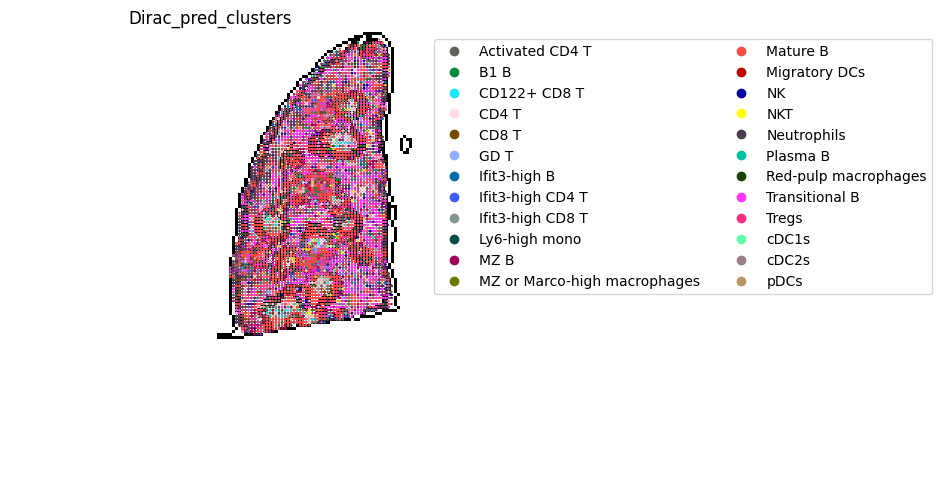

<Figure size 640x480 with 0 Axes>

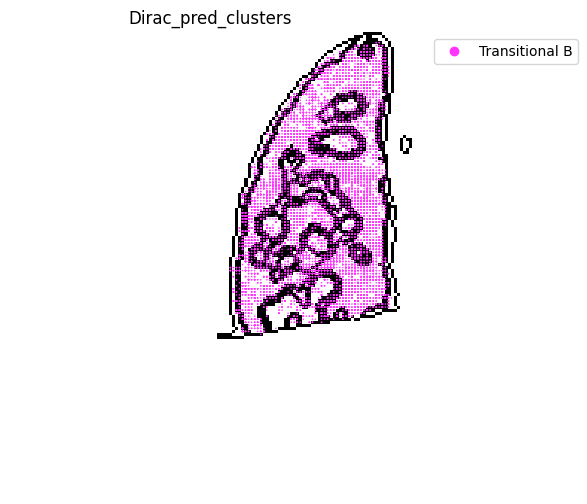

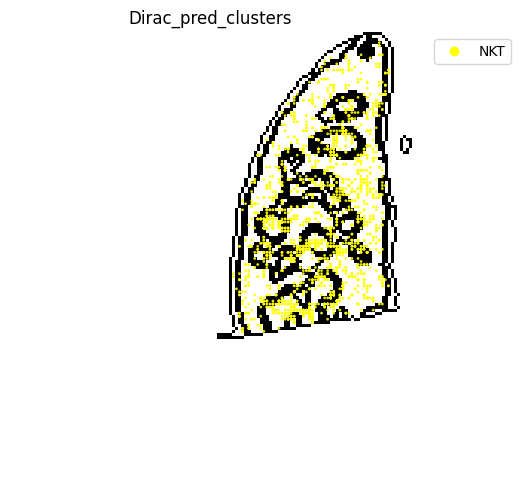

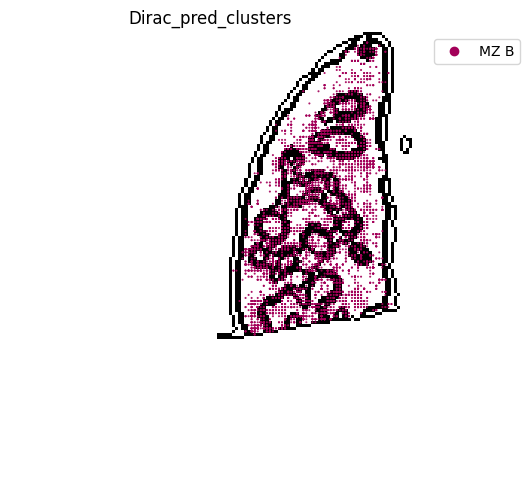

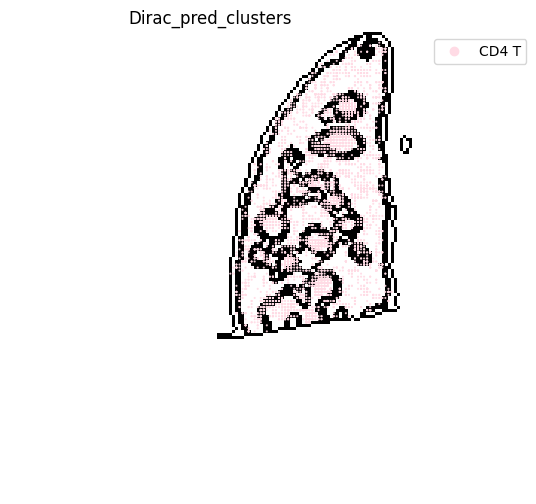

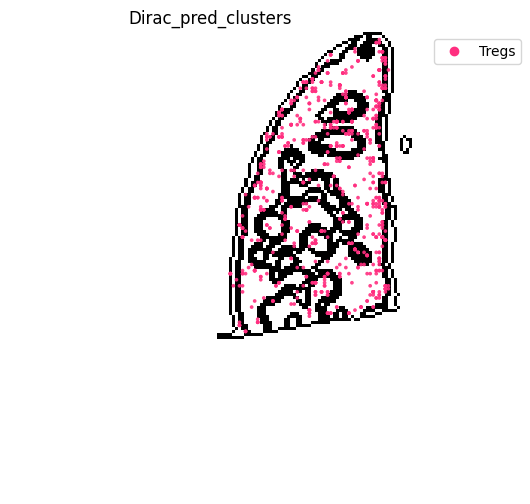

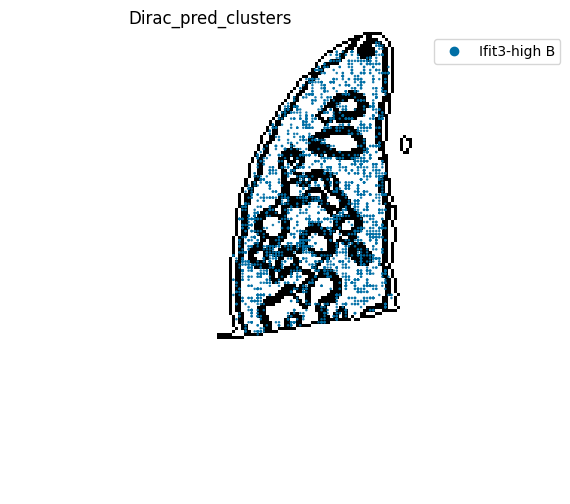

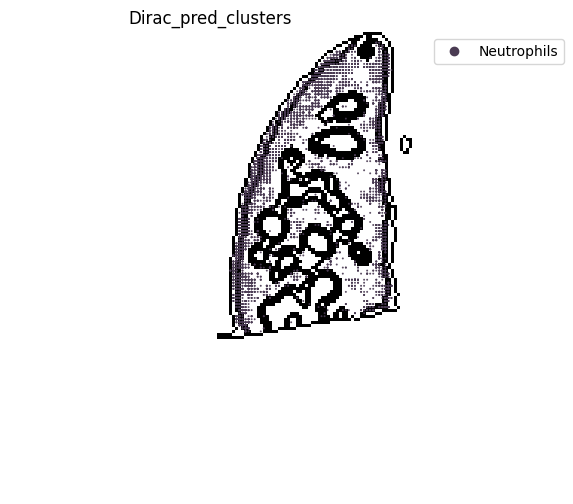

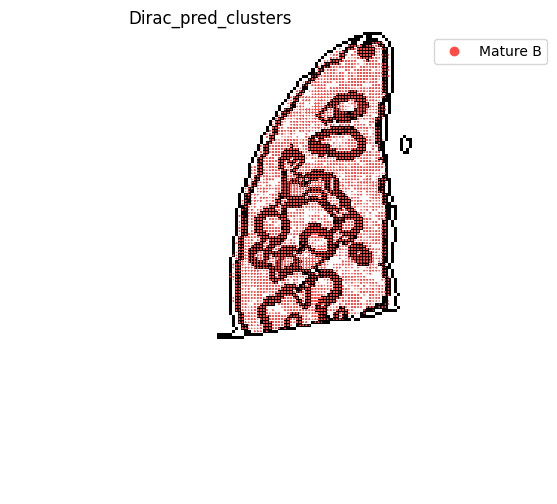

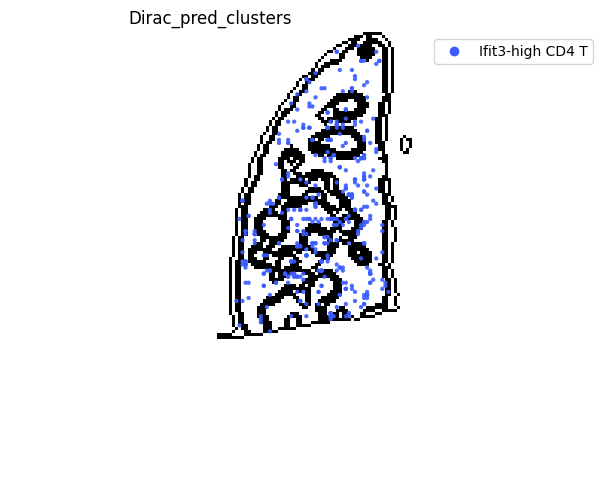

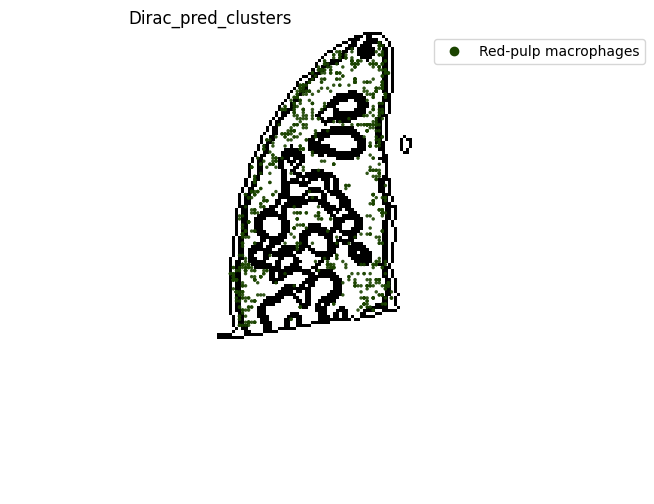

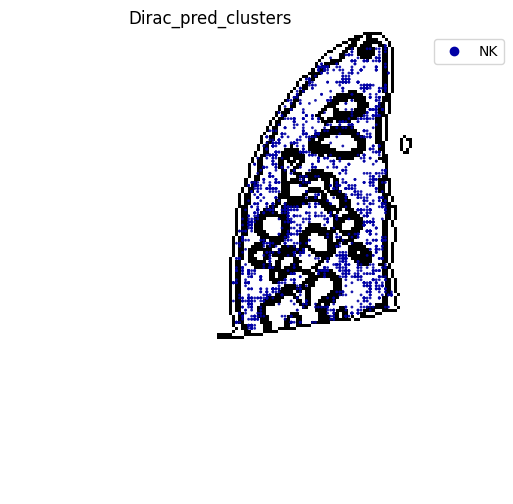

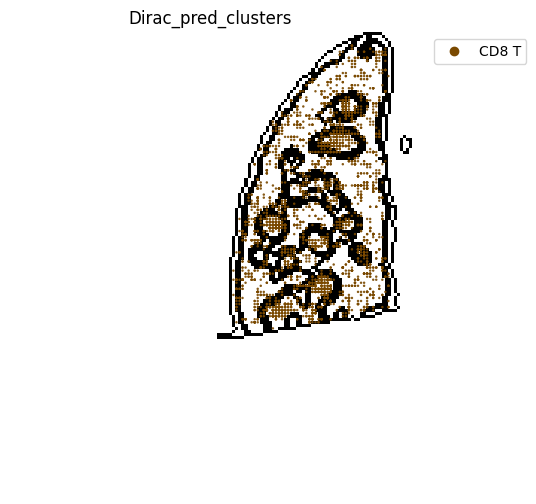

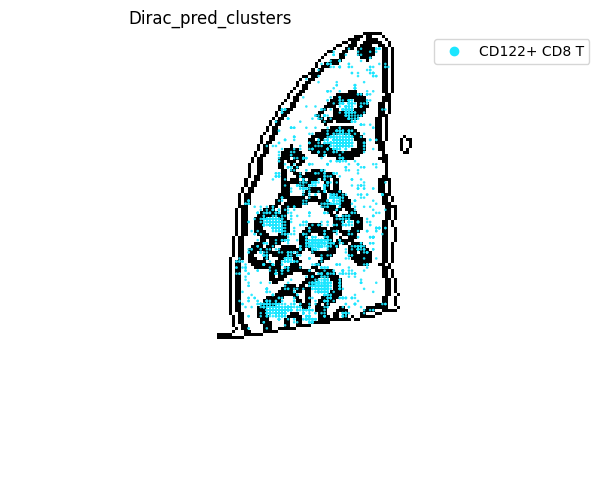

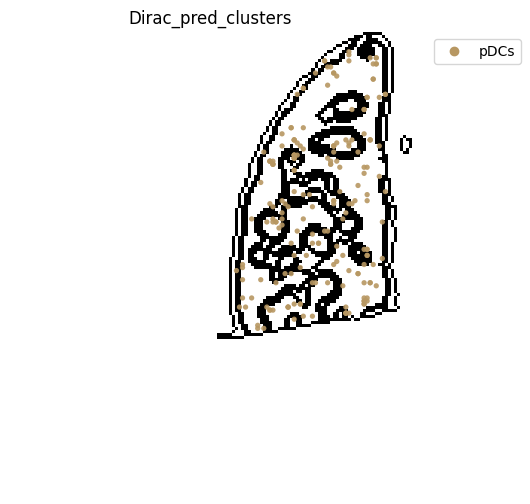

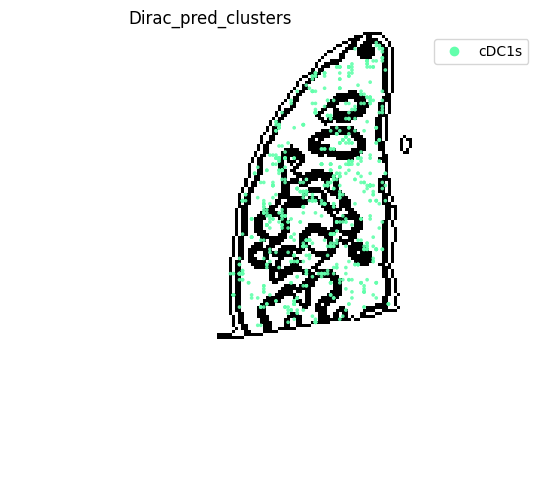

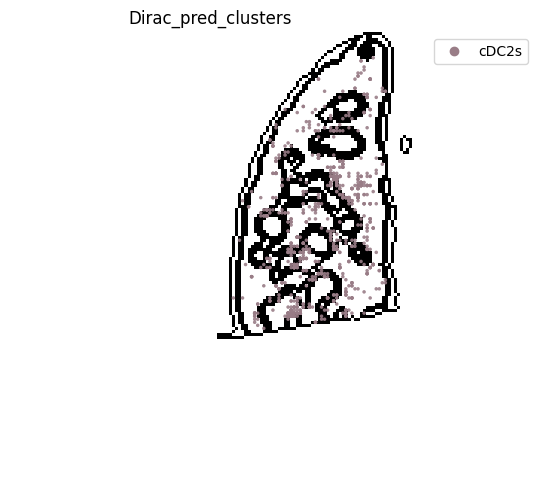

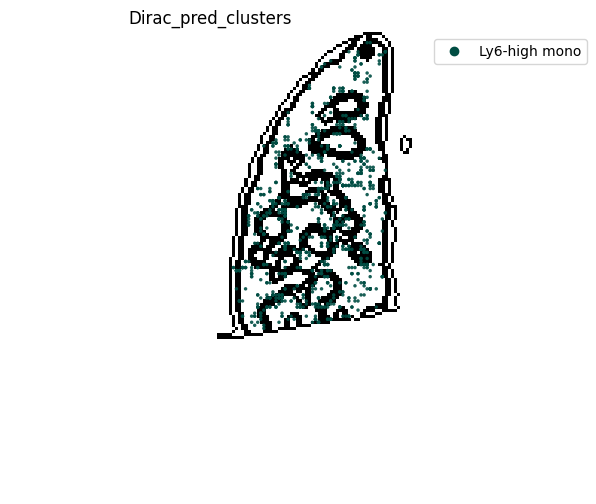

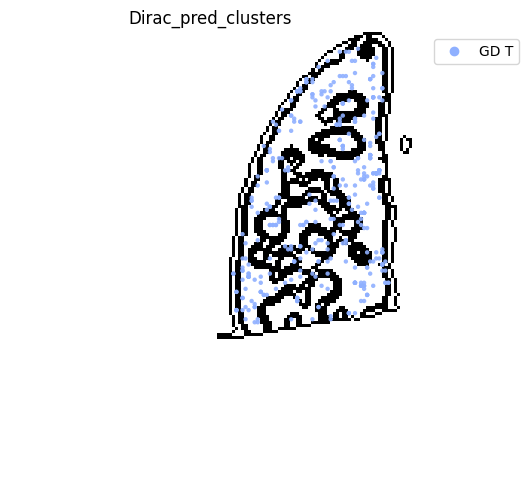

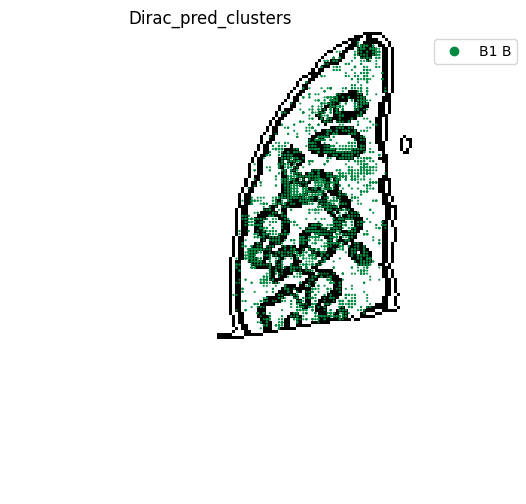

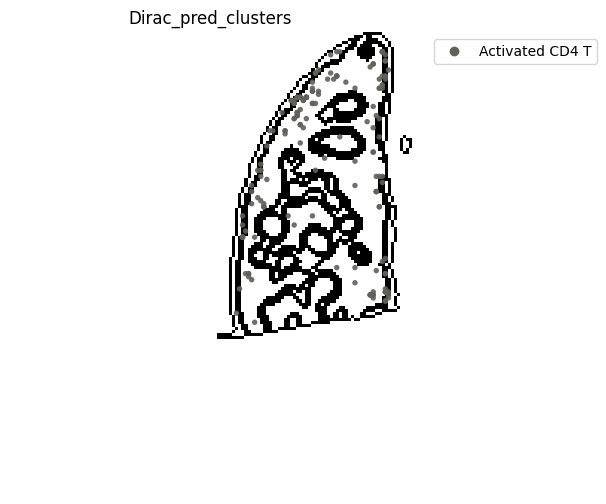

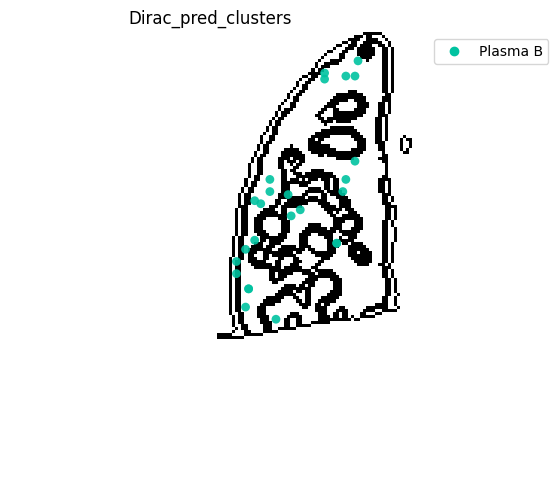

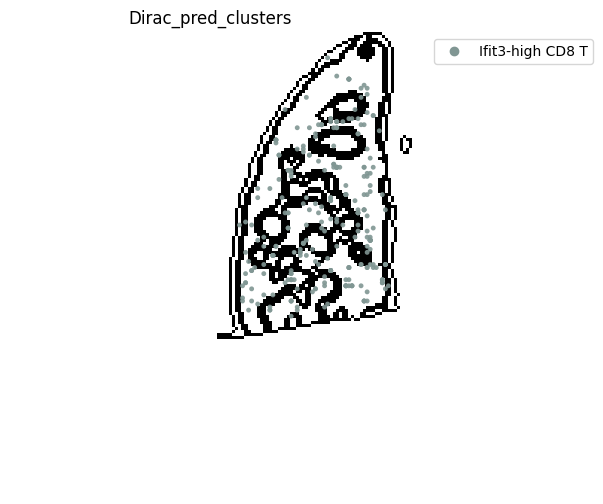

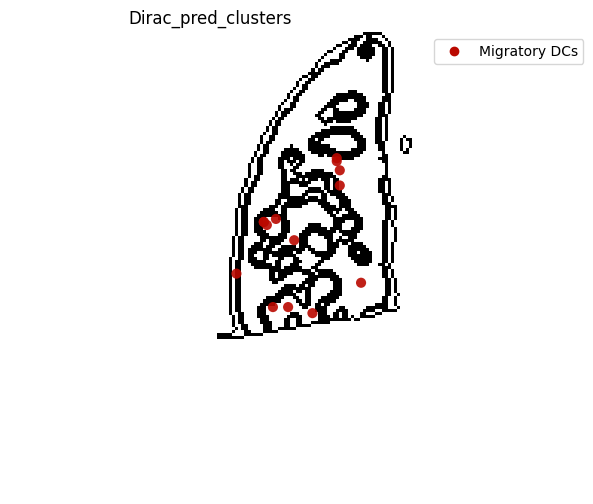

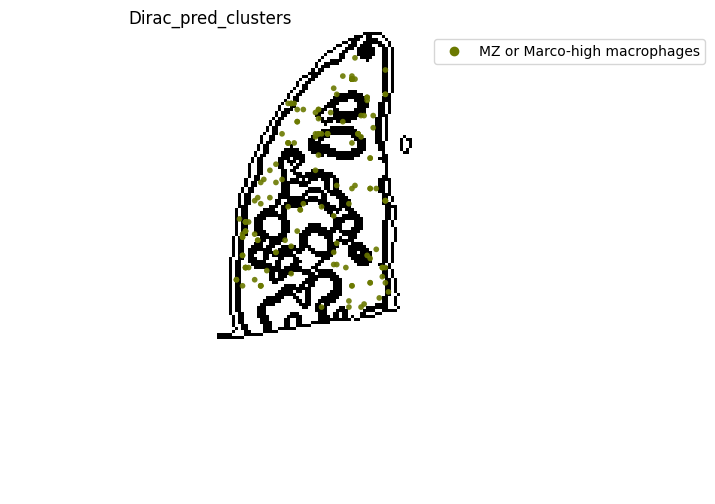

In [70]:
target_adata_RNA.obsm['spatial_bin100'] = target_adata_RNA.obsm['spatial'] // 100

target_adata_RNA = st.io.read_image(
    target_adata_RNA,
    filename=os.path.join("/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/mouse_spleen/Results/B05050G1_bin100_Dirac/20241206164031", "spatial_domains.png"),
    img_layer="layer1",
    slice="slice1",
    scale_factor=1,
)

target_adata_RNA.uns["__type"] = "UMI"

fig, ax = plt.subplots(figsize=(8, 6))
st.pl.space(
    target_adata_RNA,
    space="spatial_bin100",
    color=["Dirac_pred_clusters"],
    alpha=0.9,
    figsize=(5, 3),
    show_legend="upper left",
    img_layers = "layer1",
    slices="slice1",
    dpi=300, 
    pointsize=0.2,
    color_key = colormaps_clusters,
    ax=ax,
)
plt.tight_layout()
plt.show() 
fig.savefig(os.path.join(RNA_save_path, f"{data_name}_{methods}_cell_type_outlines.png"), dpi = 600)



save_fig_path = os.path.join(RNA_save_path, "Single_cell_type_outline")
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)

for i in target_adata_RNA.obs[f"{methods}_pred_clusters"].unique():
    fig, ax = plt.subplots(figsize=(8, 6))
    st.pl.space(
        target_adata_RNA[target_adata_RNA.obs[f"{methods}_pred_clusters"].isin([i])],
        space = "spatial_bin100",
        color = ["Dirac_pred_clusters"],
        alpha = 0.9,
        figsize = (5, 3),
        show_legend = "upper left",
        img_layers = "layer1",
        slices="slice1",
        dpi=300, 
        pointsize=0.05,
        color_key = colormaps_clusters,
        ax=ax)
    fig.savefig(os.path.join(save_fig_path, f"{data_name}_{i}.png"), dpi = 600)

######### save data
target_adata_RNA.var.rename(columns={"real_gene_name": "real_gene_name_col"}, inplace=True)
target_adata_RNA.write(os.path.join(RNA_save_path, f"{data_name}_{methods}_{use_counts}_target.h5ad"), compression="gzip")
source_adata_RNA.write(os.path.join(RNA_save_path, f"{data_name}_{methods}_{use_counts}_source.h5ad"), compression="gzip")

        domain          celltype  count
0  B cell zone              B1 B   1883
1  B cell zone      CD122+ CD8 T    177
2  B cell zone             CD4 T    322
3  B cell zone             CD8 T    173
4  B cell zone              GD T      3
5  B cell zone      Ifit3-high B    206
6  B cell zone  Ifit3-high CD4 T      3
7  B cell zone  Ifit3-high CD8 T      6
8  B cell zone     Ly6-high mono     52
9  B cell zone              MZ B   1194


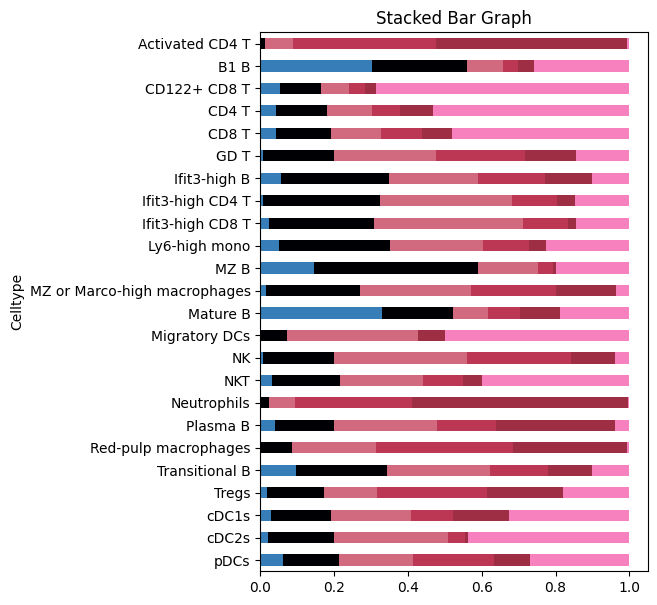

In [71]:
############## downstream at bin=50
# Summary domain-cell relationship
bin50_cluster2colors = {
    "Marginal zone": '#000004ff',
    "Capsule": '#57106eff',
    "T cell zone": "#F781BF",
    "B cell zone": "#377EB8",
    "Red pulp 1":'#d16a7fff',
    "Red pulp 2":'#bc3754ff',
    "Red pulp 3":'#9e2e44ff',
}

domain_list = np.array([])
celltype_list = np.array([])
count_list = np.array([])
for i in np.unique(target_adata_RNA.obs["region_domain_from_bin50"]):
    tmp, counts = np.unique(target_adata_RNA[target_adata_RNA.obs["region_domain_from_bin50"] == i,:].obs[f"{methods}_pred_clusters"], return_counts=True)
    domain_list = np.append(domain_list, np.repeat(i, len(counts)))
    celltype_list = np.append(celltype_list, tmp)
    count_list = np.append(count_list, counts)
hetero_df = pd.DataFrame({"domain":domain_list, "celltype":celltype_list, "count":count_list.astype(int)})

print(hetero_df[0:10])

# Cell distribution among domains
spec_df_plt = hetero_df.pivot(index="celltype", columns="domain", values="count").fillna(0)
spec_df_plt = spec_df_plt.div(spec_df_plt.sum(axis=1), axis=0)

spec_df_plt['Celltype'] = spec_df_plt.index
spec_df_plt.index = pd.CategoricalIndex(spec_df_plt.index, categories=spec_df_plt.index.astype(str).sort_values())
spec_df_plt = spec_df_plt.sort_index(ascending=False)


ax = spec_df_plt.plot(
    x = 'Celltype',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True,
    figsize=(5, 7),
    legend = False,
    color = bin50_cluster2colors,
)

# Save the plot
plt.savefig(os.path.join(RNA_save_path, f"{data_name}_bin100_celltype_distribution.pdf"), dpi = 600)
plt.show()

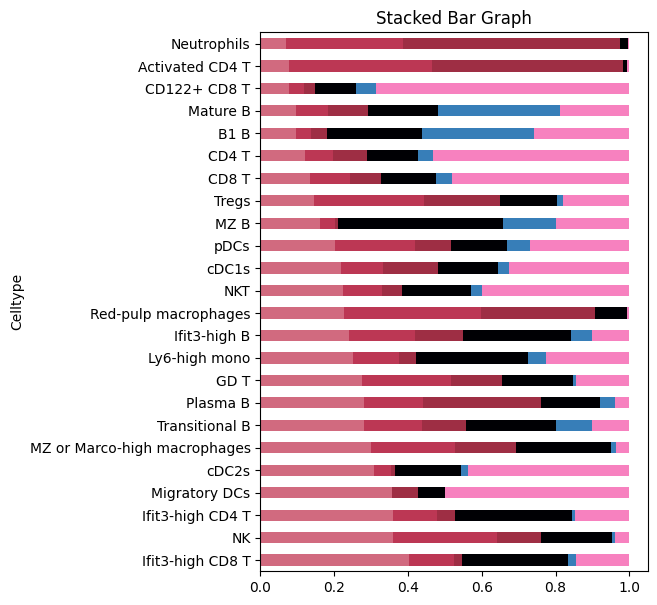

In [73]:
# Define the order of regions
desired_order = ["Red pulp 1", "Red pulp 2", "Red pulp 3", "Marginal zone", "B cell zone", "T cell zone"]

# Rearrange the columns based on the desired region order (temporarily excluding 'Celltype')
spec_df_plt = spec_df_plt[desired_order + ['Celltype']]

# Create a new DataFrame to store the sorted data
sorted_spec_df_plt = pd.DataFrame()

# Sort the cell types by proportion in descending order for each region
for region in desired_order:
    # Sort the cell types for the current region
    region_df = spec_df_plt.sort_values(by=region, ascending=False)
    sorted_spec_df_plt = pd.concat([sorted_spec_df_plt, region_df])

# Remove duplicates while preserving the order (keeping the first occurrence)
sorted_spec_df_plt = sorted_spec_df_plt.drop_duplicates(subset=['Celltype'], keep='first')

# Reset the index to ensure the order of the bar chart is correct
sorted_spec_df_plt.index = pd.CategoricalIndex(sorted_spec_df_plt['Celltype'], categories=sorted_spec_df_plt['Celltype'], ordered=True)

# Rearrange the columns to maintain the desired region order along with 'Celltype'
sorted_spec_df_plt = sorted_spec_df_plt[desired_order + ['Celltype']]

# Plot the stacked horizontal bar chart
ax = sorted_spec_df_plt.plot(
    x='Celltype',
    kind='barh',
    stacked=True,
    title='Stacked Bar Graph',
    mark_right=True,
    figsize=(5, 7),
    legend=False,
    color=bin50_cluster2colors,
)

# Save the figure
plt.savefig(os.path.join(RNA_save_path, f"{data_name}_bin100_celltype_distribution.pdf"), dpi=600)
plt.show()

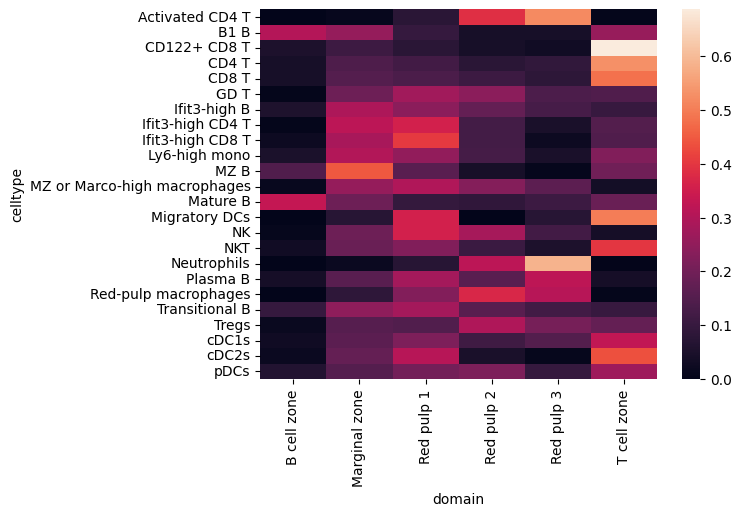

In [74]:
# Cell composition within each domain
import seaborn as sns
hetero_df_plt = hetero_df[hetero_df.domain!="NA"].pivot(index="domain", columns="celltype", values="count").fillna(0)
hetero_df_plt = hetero_df_plt.div(hetero_df_plt.sum(axis=0), axis=1)

ax = sns.heatmap(hetero_df_plt.T)
plt.savefig(os.path.join(RNA_save_path, f"{data_name}_bin100_celltype_heatmap.pdf"), dpi = 600)
plt.show()

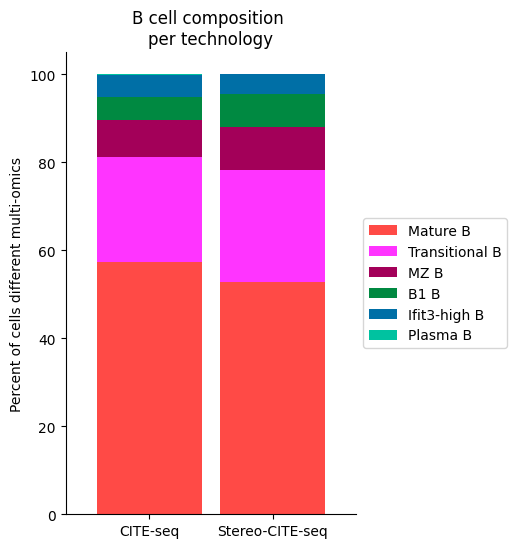

In [75]:
############
# Use this ordering of cell types for consistency
import seaborn as sns

Bcell_clust_onevall = ['Plasma B', 'Transitional B', 'Mature B', 'Ifit3-high B', 'B1 B', 'MZ B']

# Plot composition of spleen and lymph node B cell subsets as a stacked bar chart

# Calculate cluster composition of each tissue
# Get spleen/LN cells
source_spleen_B = source_adata_RNA[source_adata_RNA.obs["cell_types"].isin(Bcell_clust_onevall)]
target_spleen_B = target_adata_RNA[target_adata_RNA.obs["Dirac_pred_clusters"].isin(Bcell_clust_onevall)]


# Get cluster labels
source_spleen_clusters = pd.Series(source_spleen_B.obs["cell_types"].values)
target_spleen_clusters = pd.Series(target_spleen_B.obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp  = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp = target_spleen_clusters.value_counts()/np.sum(target_spleen_clusters.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, "Stereo-CITE-seq": target_spleen_comp}))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("B cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(RNA_save_path,"Bcell_composition_per_tissue.pdf"), dpi=300, bbox_inches='tight')

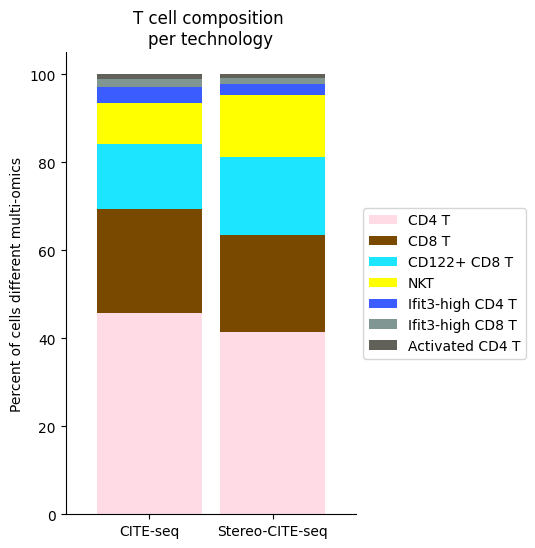

In [76]:
############
# Use this ordering of cell types for consistency
import seaborn as sns

Tcell_clust_onevall = ['Ifit3-high CD4 T','CD4 T', 'CD8 T', 'CD122+ CD8 T', 'Ifit3-high CD8 T', 'Activated CD4 T','NKT']

# Plot composition of spleen and lymph node B cell subsets as a stacked bar chart

# Calculate cluster composition of each tissue
# Get spleen/LN cells
source_spleen_T = source_adata_RNA[source_adata_RNA.obs["cell_types"].isin(Tcell_clust_onevall)]
target_spleen_T = target_adata_RNA[target_adata_RNA.obs["Dirac_pred_clusters"].isin(Tcell_clust_onevall)]


# Get cluster labels
source_spleen_clusters = pd.Series(source_spleen_T.obs["cell_types"].values)
target_spleen_clusters = pd.Series(target_spleen_T.obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp  = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp = target_spleen_clusters.value_counts()/np.sum(target_spleen_clusters.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, "Stereo-CITE-seq": target_spleen_comp}))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("T cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(RNA_save_path,"Tcell_composition_per_tissue.pdf"), dpi=300, bbox_inches='tight')

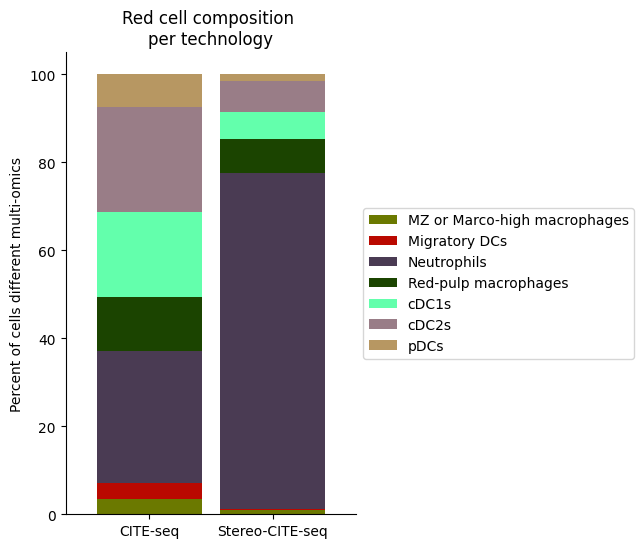

In [77]:
############
# Use this ordering of cell types for consistency
import seaborn as sns

Rcell_clust_onevall = ['Red-pulp macrophages', 'Migratory DCs', 'pDCs', 'cDC1s', 'cDC2s','Neutrophils', 'MZ or Marco-high macrophages']

# Plot composition of spleen and lymph node B cell subsets as a stacked bar chart

# Calculate cluster composition of each tissue
# Get spleen/LN cells
source_spleen_R = source_adata_RNA[source_adata_RNA.obs["cell_types"].isin(Rcell_clust_onevall)]
target_spleen_R = target_adata_RNA[target_adata_RNA.obs["Dirac_pred_clusters"].isin(Rcell_clust_onevall)]


# Get cluster labels
source_spleen_clusters = pd.Series(source_spleen_R.obs["cell_types"].values)
target_spleen_clusters = pd.Series(target_spleen_R.obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp  = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp = target_spleen_clusters.value_counts()/np.sum(target_spleen_clusters.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, "Stereo-CITE-seq": target_spleen_comp}))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(3.75, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("Red cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(RNA_save_path,"Rcell_composition_per_tissue.pdf"), dpi=300, bbox_inches='tight')

In [78]:
RNA_save_path = "/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/section5/Results/C03833D6_cellbin_Dirac_annotation/20241107183627_final"

## Step 3: Comparison of cell proportions, including CITE-seq, Stereo-CITE-seq (Joint, Only RNA, Only Protein)

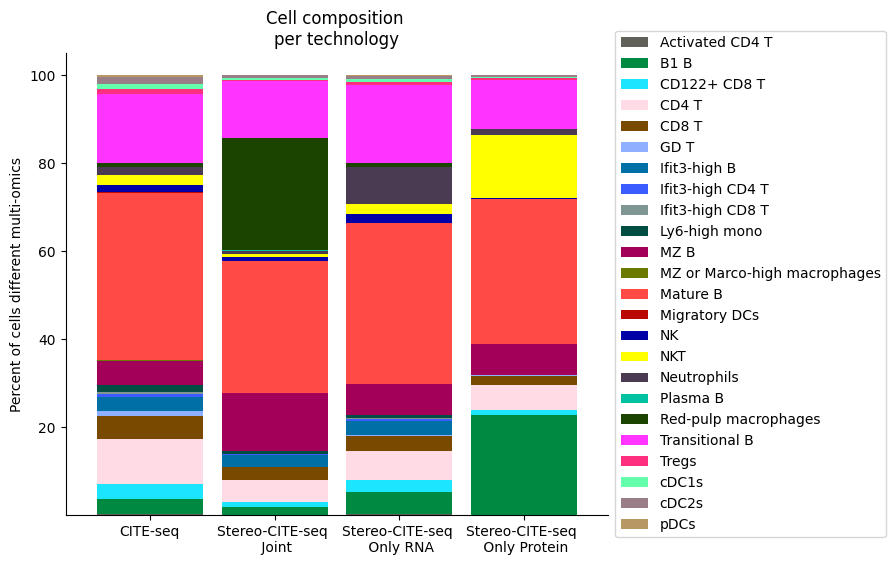

In [79]:
# Use this ordering of cell types for consistency
import seaborn as sns

# Get cluster labels
source_spleen_clusters = pd.Series(source_adata_total.obs["cell_types"].values)
target_spleen_clusters_total = pd.Series(target_adata_total.obs["Dirac_pred_clusters"].values)
target_spleen_clusters_RNA = pd.Series(target_adata_RNA.obs["Dirac_pred_clusters"].values)
target_spleen_clusters_Protein = pd.Series(target_adata_protein.obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp_total = target_spleen_clusters_total.value_counts()/np.sum(target_spleen_clusters_total.value_counts())*100
target_spleen_comp_RNA = target_spleen_clusters_RNA.value_counts()/np.sum(target_spleen_clusters_RNA.value_counts())*100
target_spleen_comp_Protein = target_spleen_clusters_Protein.value_counts()/np.sum(target_spleen_clusters_Protein.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, 
                                            "Stereo-CITE-seq \n Joint": target_spleen_comp_total, 
                                            "Stereo-CITE-seq \n Only RNA": target_spleen_comp_RNA,
                                            "Stereo-CITE-seq \n Only Protein": target_spleen_comp_Protein,
                                           }))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(7, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("Cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(save_path,"allcell_composition_per_tissue_including_Protein_RNA_joint.pdf"), dpi=300, bbox_inches='tight')

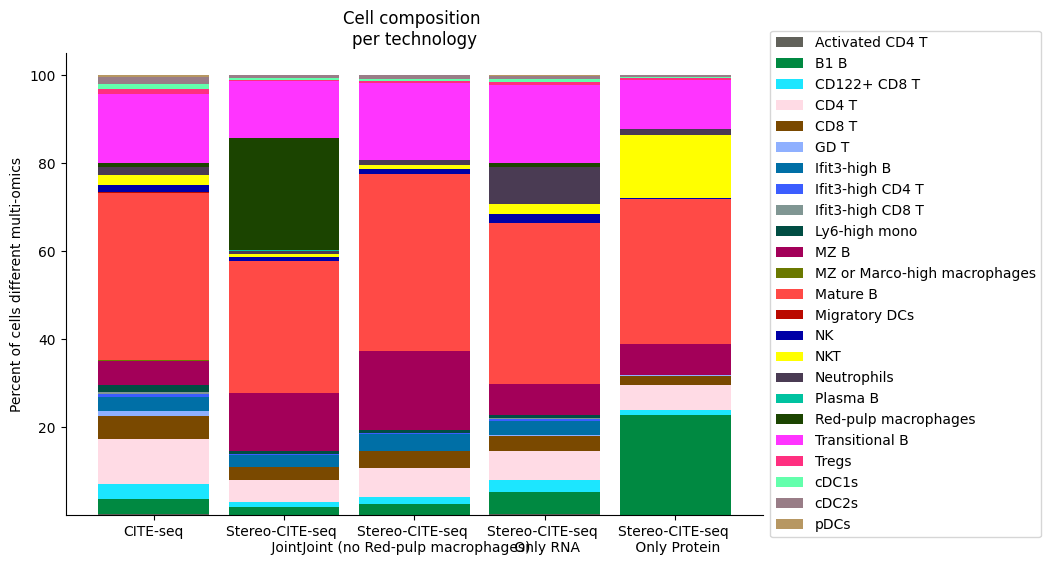

In [80]:
# Use this ordering of cell types for consistency
import seaborn as sns


# Get cluster labels
source_spleen_clusters = pd.Series(source_adata_total.obs["cell_types"].values)
target_spleen_clusters_total = pd.Series(target_adata_total.obs["Dirac_pred_clusters"].values)
target_spleen_clusters_RNA = pd.Series(target_adata_RNA.obs["Dirac_pred_clusters"].values)
target_spleen_clusters_Protein = pd.Series(target_adata_protein.obs["Dirac_pred_clusters"].values)
target_spleen_clusters_Ery = pd.Series(target_adata_total[~target_adata_total.obs["Dirac_pred_clusters"].isin(['Red-pulp macrophages'])].obs["Dirac_pred_clusters"].values)

# Calculate cluster composition (cells as a percent of total in that tissue)
source_spleen_comp = source_spleen_clusters.value_counts()/np.sum(source_spleen_clusters.value_counts())*100
target_spleen_comp_total = target_spleen_clusters_total.value_counts()/np.sum(target_spleen_clusters_total.value_counts())*100
target_spleen_comp_RNA = target_spleen_clusters_RNA.value_counts()/np.sum(target_spleen_clusters_RNA.value_counts())*100
target_spleen_comp_Protein = target_spleen_clusters_Protein.value_counts()/np.sum(target_spleen_clusters_Protein.value_counts())*100
target_spleen_comp_Ery = target_spleen_clusters_Ery.value_counts()/np.sum(target_spleen_clusters_Ery.value_counts())*100

# Make data frame of composition

composition_df = np.transpose(pd.DataFrame({"CITE-seq":source_spleen_comp, 
                                            "Stereo-CITE-seq \n Joint": target_spleen_comp_total, 
                                            "Stereo-CITE-seq \n Joint (no Red-pulp macrophages)": target_spleen_comp_Ery,
                                            "Stereo-CITE-seq \n Only RNA": target_spleen_comp_RNA,
                                            "Stereo-CITE-seq \n Only Protein": target_spleen_comp_Protein,
                                           }))
composition_df

# Plot tissue composition as stacked bar chart

fig, ax = plt.subplots(figsize=(9, 6)) # 5,8

composition_df.plot.bar(stacked = True, ax = ax, width = 0.85, color=colormaps_clusters),
plt.ylabel("Percent of cells different multi-omics")
plt.title("Cell composition \nper technology")
ax.legend(bbox_to_anchor = (1, 0.5), loc = "center left") # move legend to outside of plot
plt.xticks(rotation = 0)
sns.despine()

fig.savefig(os.path.join(save_path,"allcell_composition_per_tissue_including_Protein_RNA_joint_Red_pulp_macrophages.pdf"), dpi=300, bbox_inches='tight')

In [81]:
save_path

'/home/project/11003054/changxu/Projects/SpaGNNs/Review/Re_2024_10_29/mouse_spleen/Results/B05050G1_cellbin_Dirac/20241207160345'

In [82]:
target_adata_total

AnnData object with n_obs × n_vars = 120117 × 552
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'region_domain_from_bins', 'region_domain_from_bin50', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'batch', 'Dirac_confs', 'Dirac_pred_num', 'Dirac_pred_clusters'
    var: 'mean', 'std'
    uns: 'log1p', 'Dirac_pred_clusters_colors', '__type', 'spatial'
    obsm: 'spatial', 'X_HVG', 'Dirac_embed', 'spatial_bin100', 'X_spatial_bin100'

In [83]:
source_adata_total

AnnData object with n_obs × n_vars = 16035 × 552
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'cell_types_num', 'batch'
    var: 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca', 'X_HVG', 'Dirac_embed'
    varm: 'PCs'